Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](img/descargar.png)

In [1]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=10,repr.plot.width=10,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [2]:
airbnb<-airbnb[,c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [3]:
df_madrid<-subset(airbnb[airbnb$City=='Madrid' & airbnb$Room.Type=='Entire home/apt' & airbnb$Neighbourhood!='',], select=-c(Room.Type,City))

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [4]:
#Primero me creo una variable para tener los metros cuadrados
df_madrid$Square.Meters<-df_madrid$Square.Feet*0.092903

In [5]:
sum(is.na(df_madrid$Square.Meters))/nrow(df_madrid)*100

[1] 93.80468

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [6]:
sum(na.omit(df_madrid$Square.Meters==0))/length(na.omit(df_madrid$Square.Meters))*100

[1] 36.88761

Reemplazar todos los 0m^2 por NA 

In [7]:
df_madrid$Square.Meters[df_madrid$Square.Meters==0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

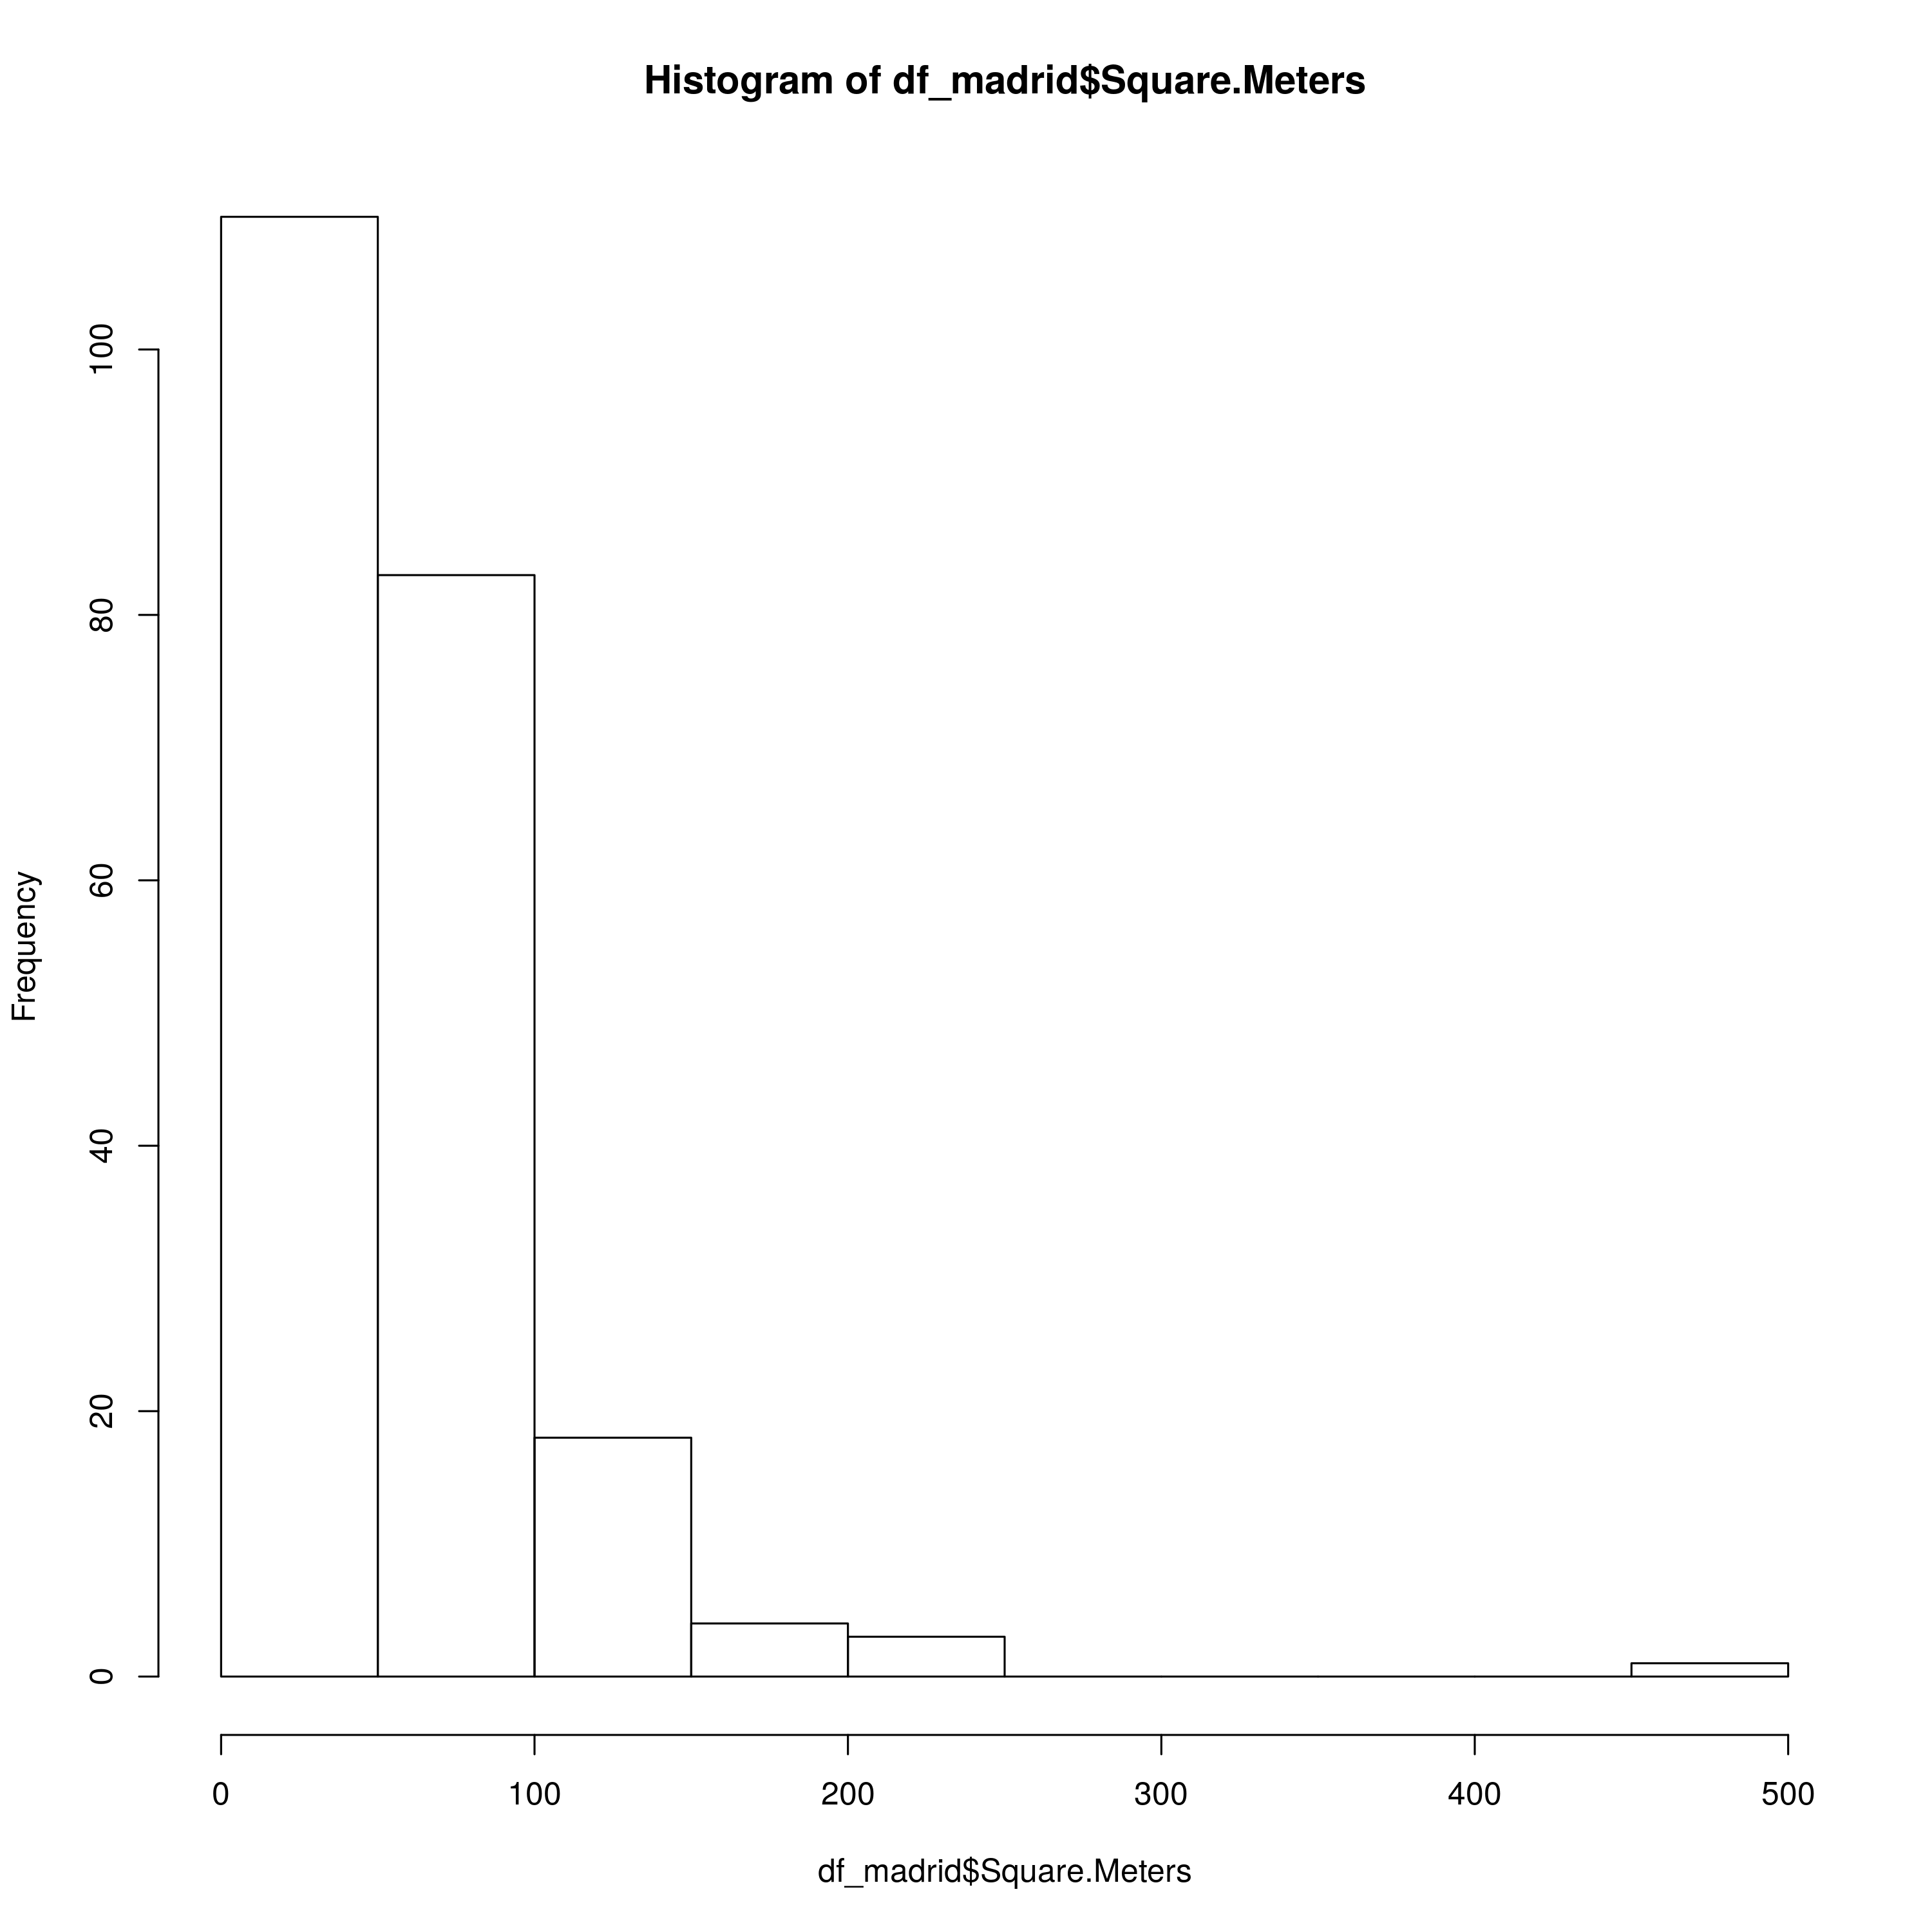

In [8]:
hist(df_madrid$Square.Meters)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
2368,Jerónimos,16,5,5,13,365,5167,5,37,98,40.41826,-3.690208,480.0298


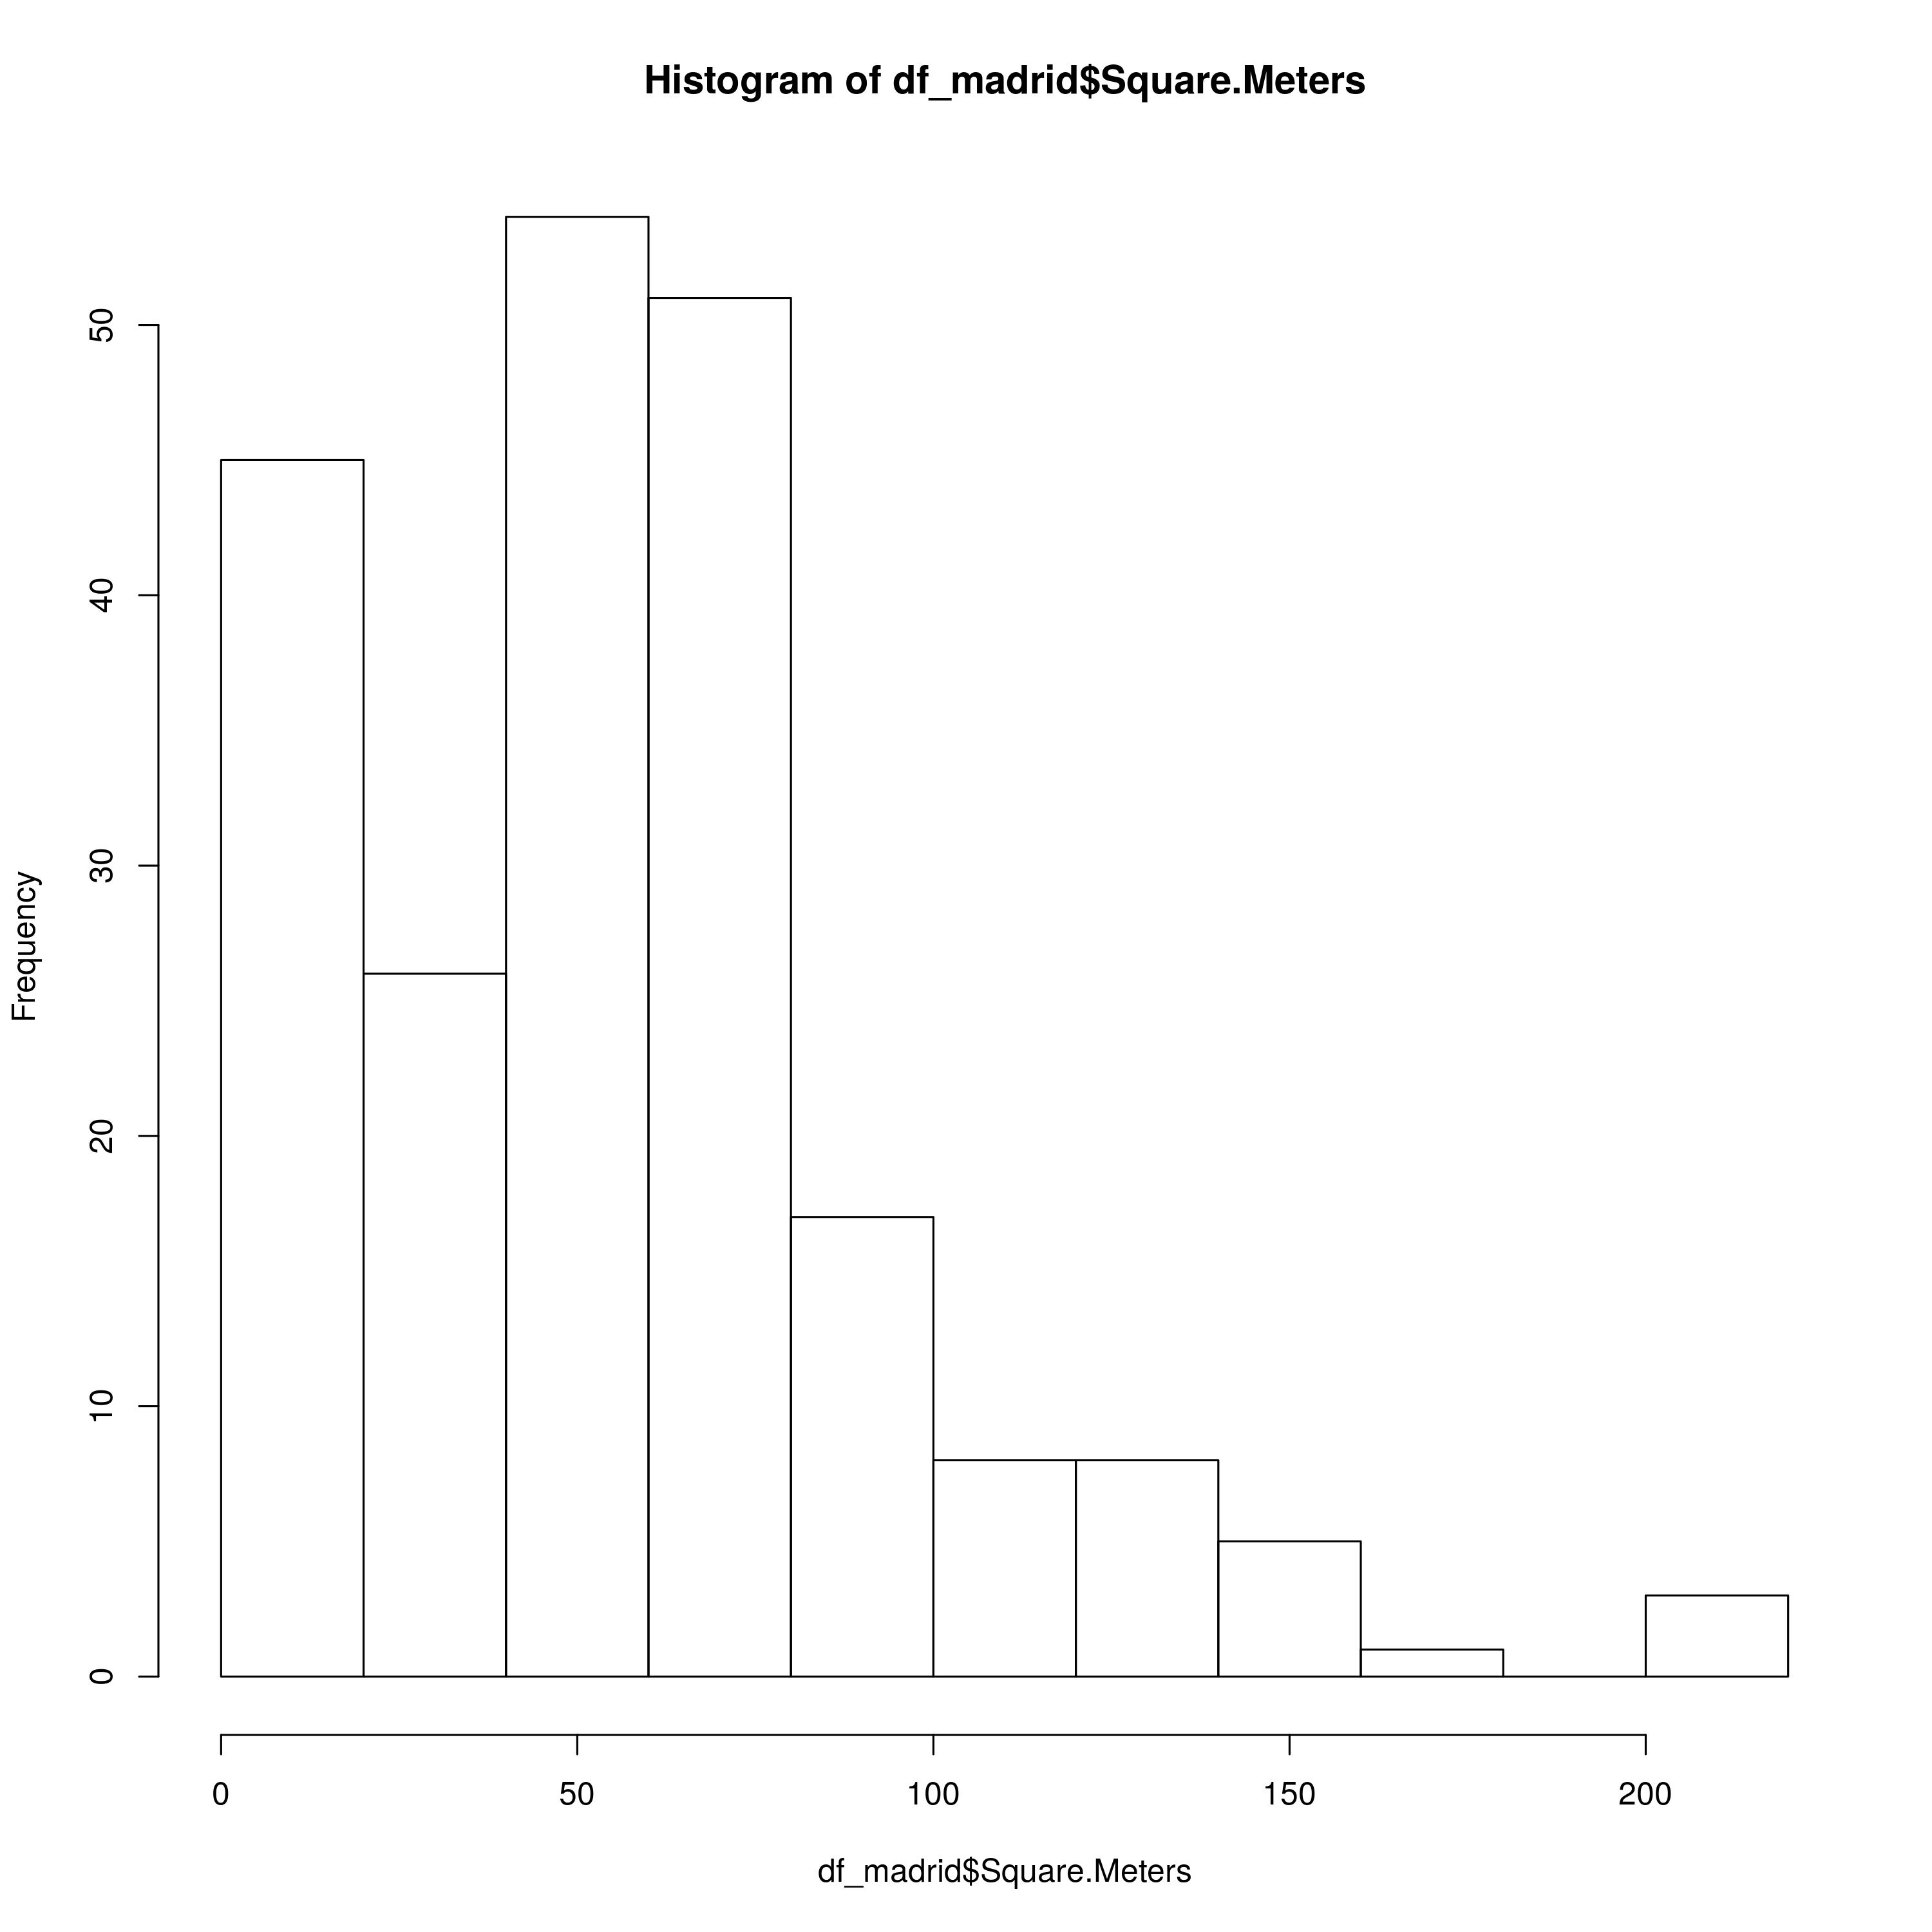

In [9]:
# Tenemos un valor que supera los 450 y puede considerarse un outlayer
na.omit(df_madrid[df_madrid$Square.Meters>450,])

# Al tratarse de un único caso aislado que supera por más del doble al siguiente apartamento más grande, optaré por eliminarlo del dataframe
df_madrid <- df_madrid[-which(df_madrid$Square.Meters>450),]

hist(df_madrid$Square.Meters)

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [10]:
df_madrid$Square.Meters[df_madrid$Square.Meters<20] <- NA

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

Warning message in resm[lower.tri(resm)] <- round(tky.result$p.adj, 4):
“number of items to replace is not a multiple of replacement length”


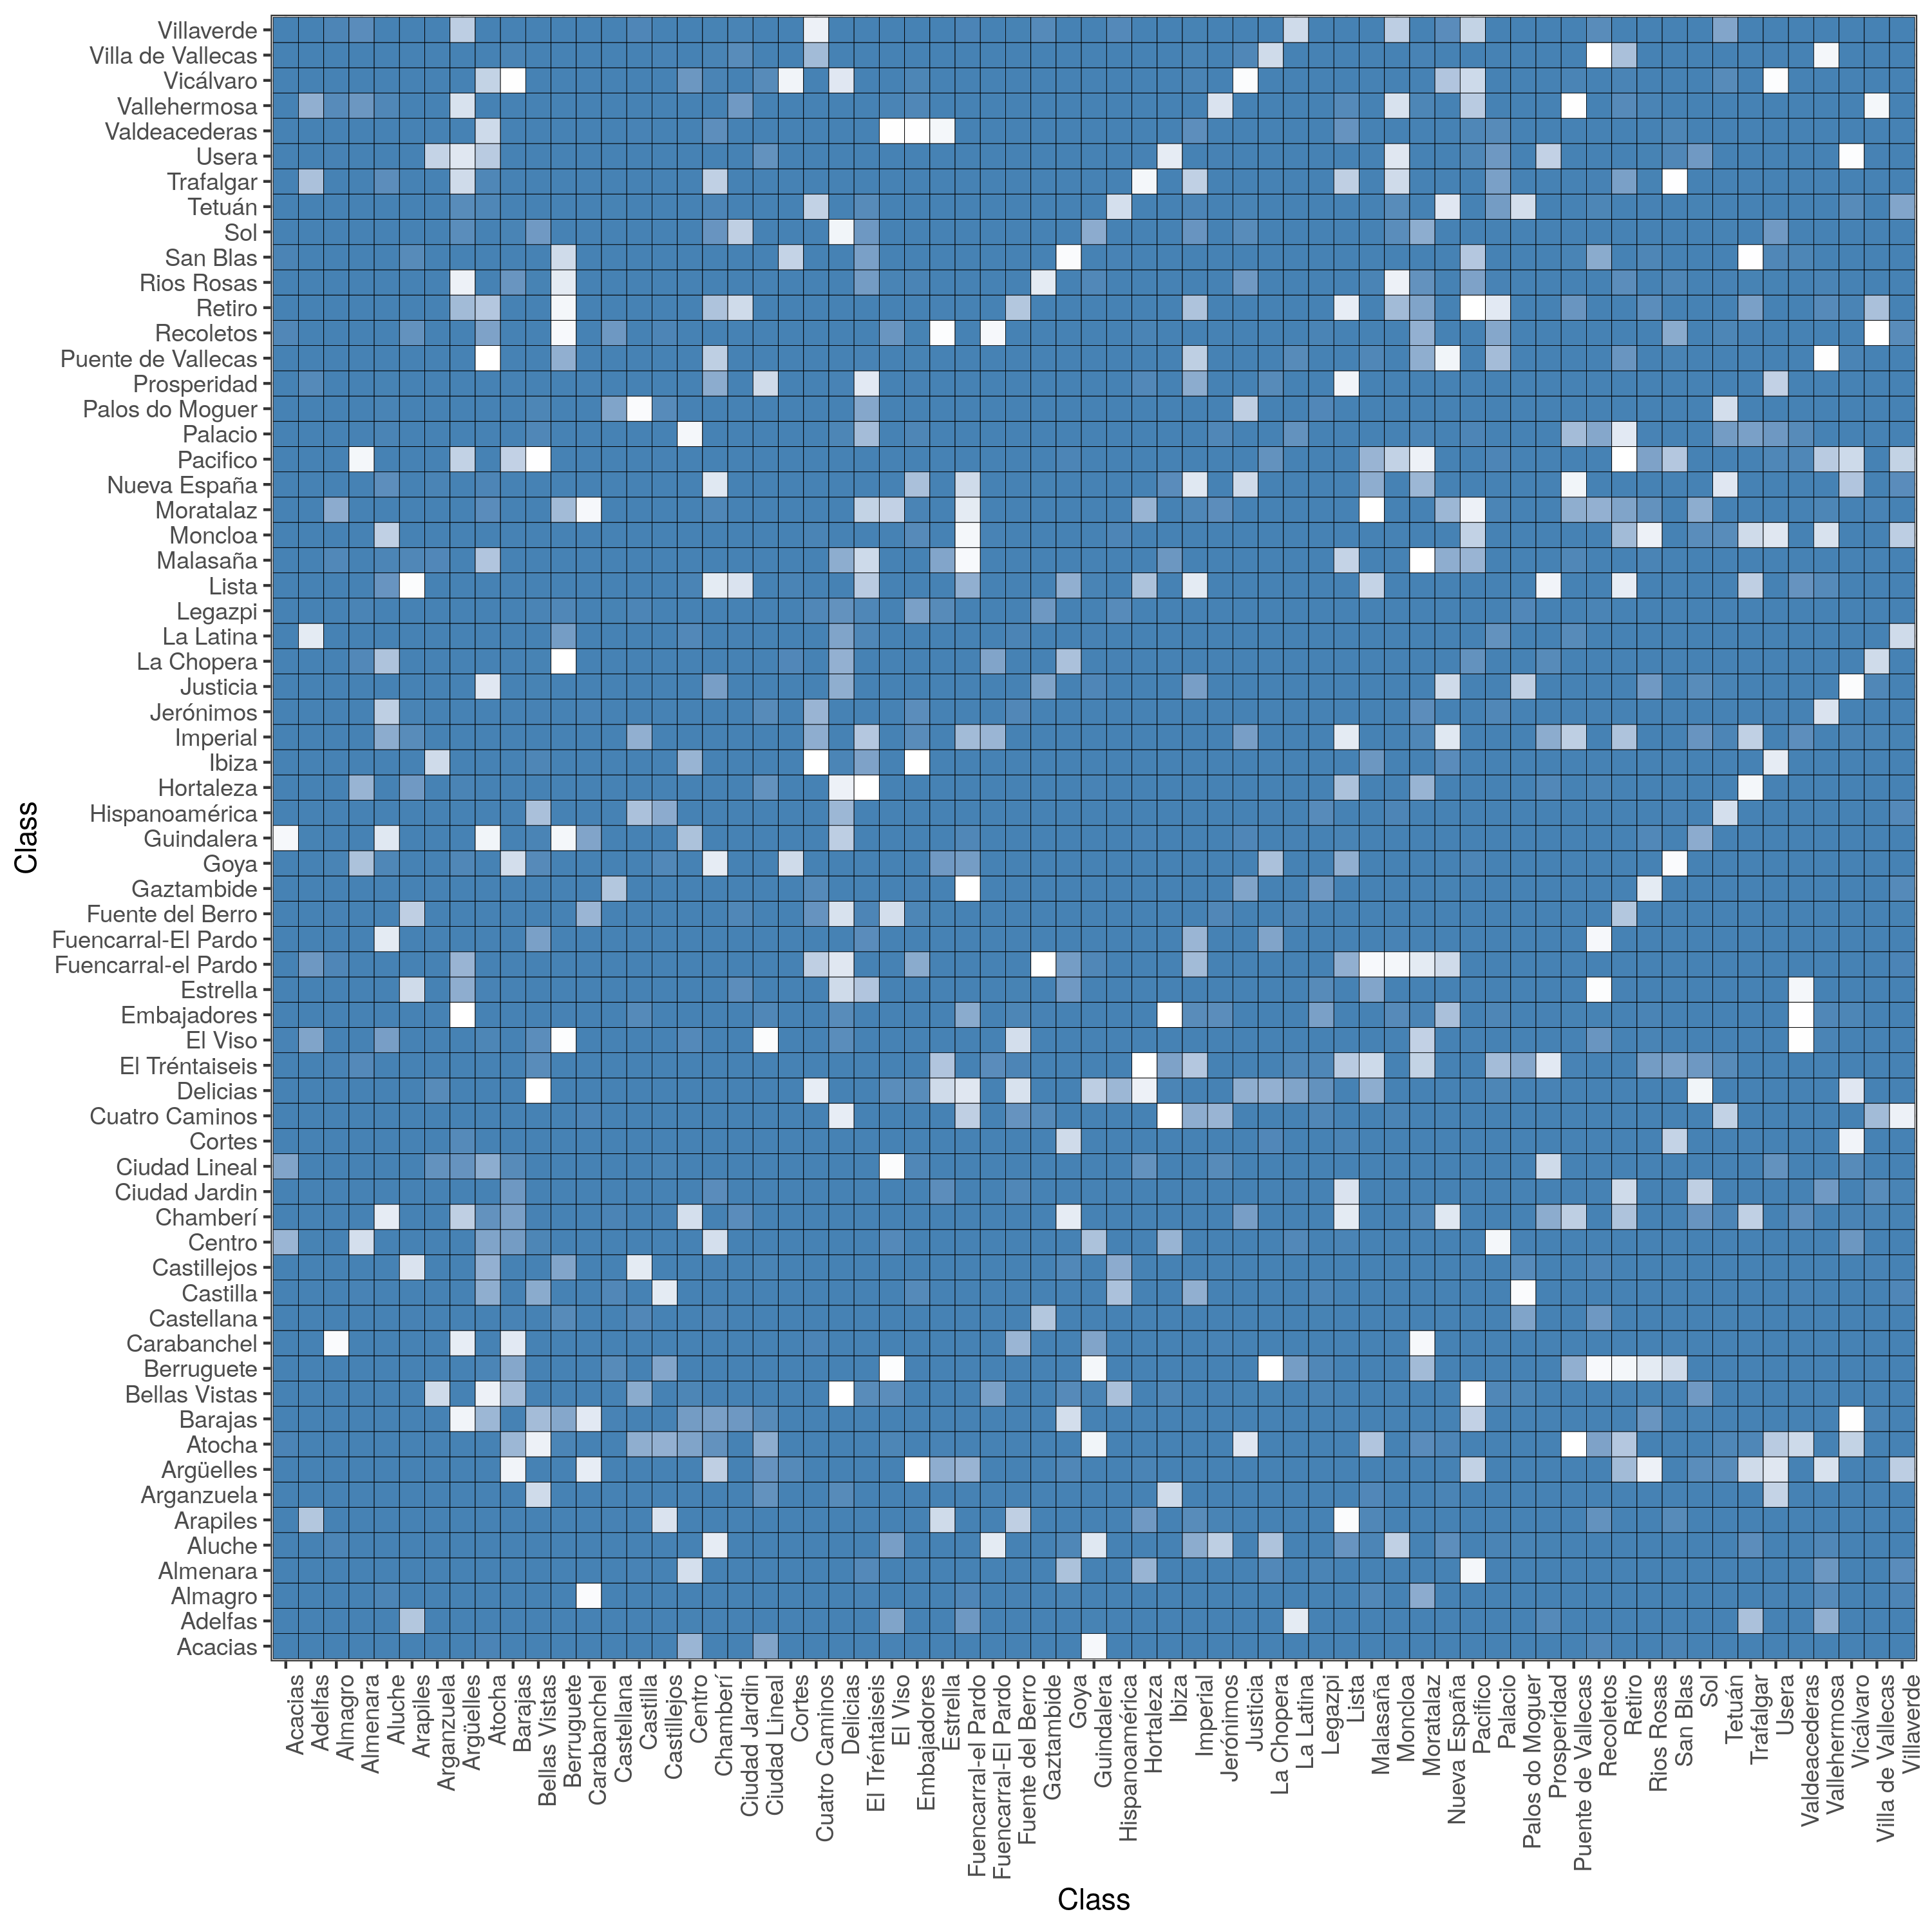

In [11]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [12]:
hc <- hclust(dist(1-resm))
hcd <-as.dendrogram(hc)

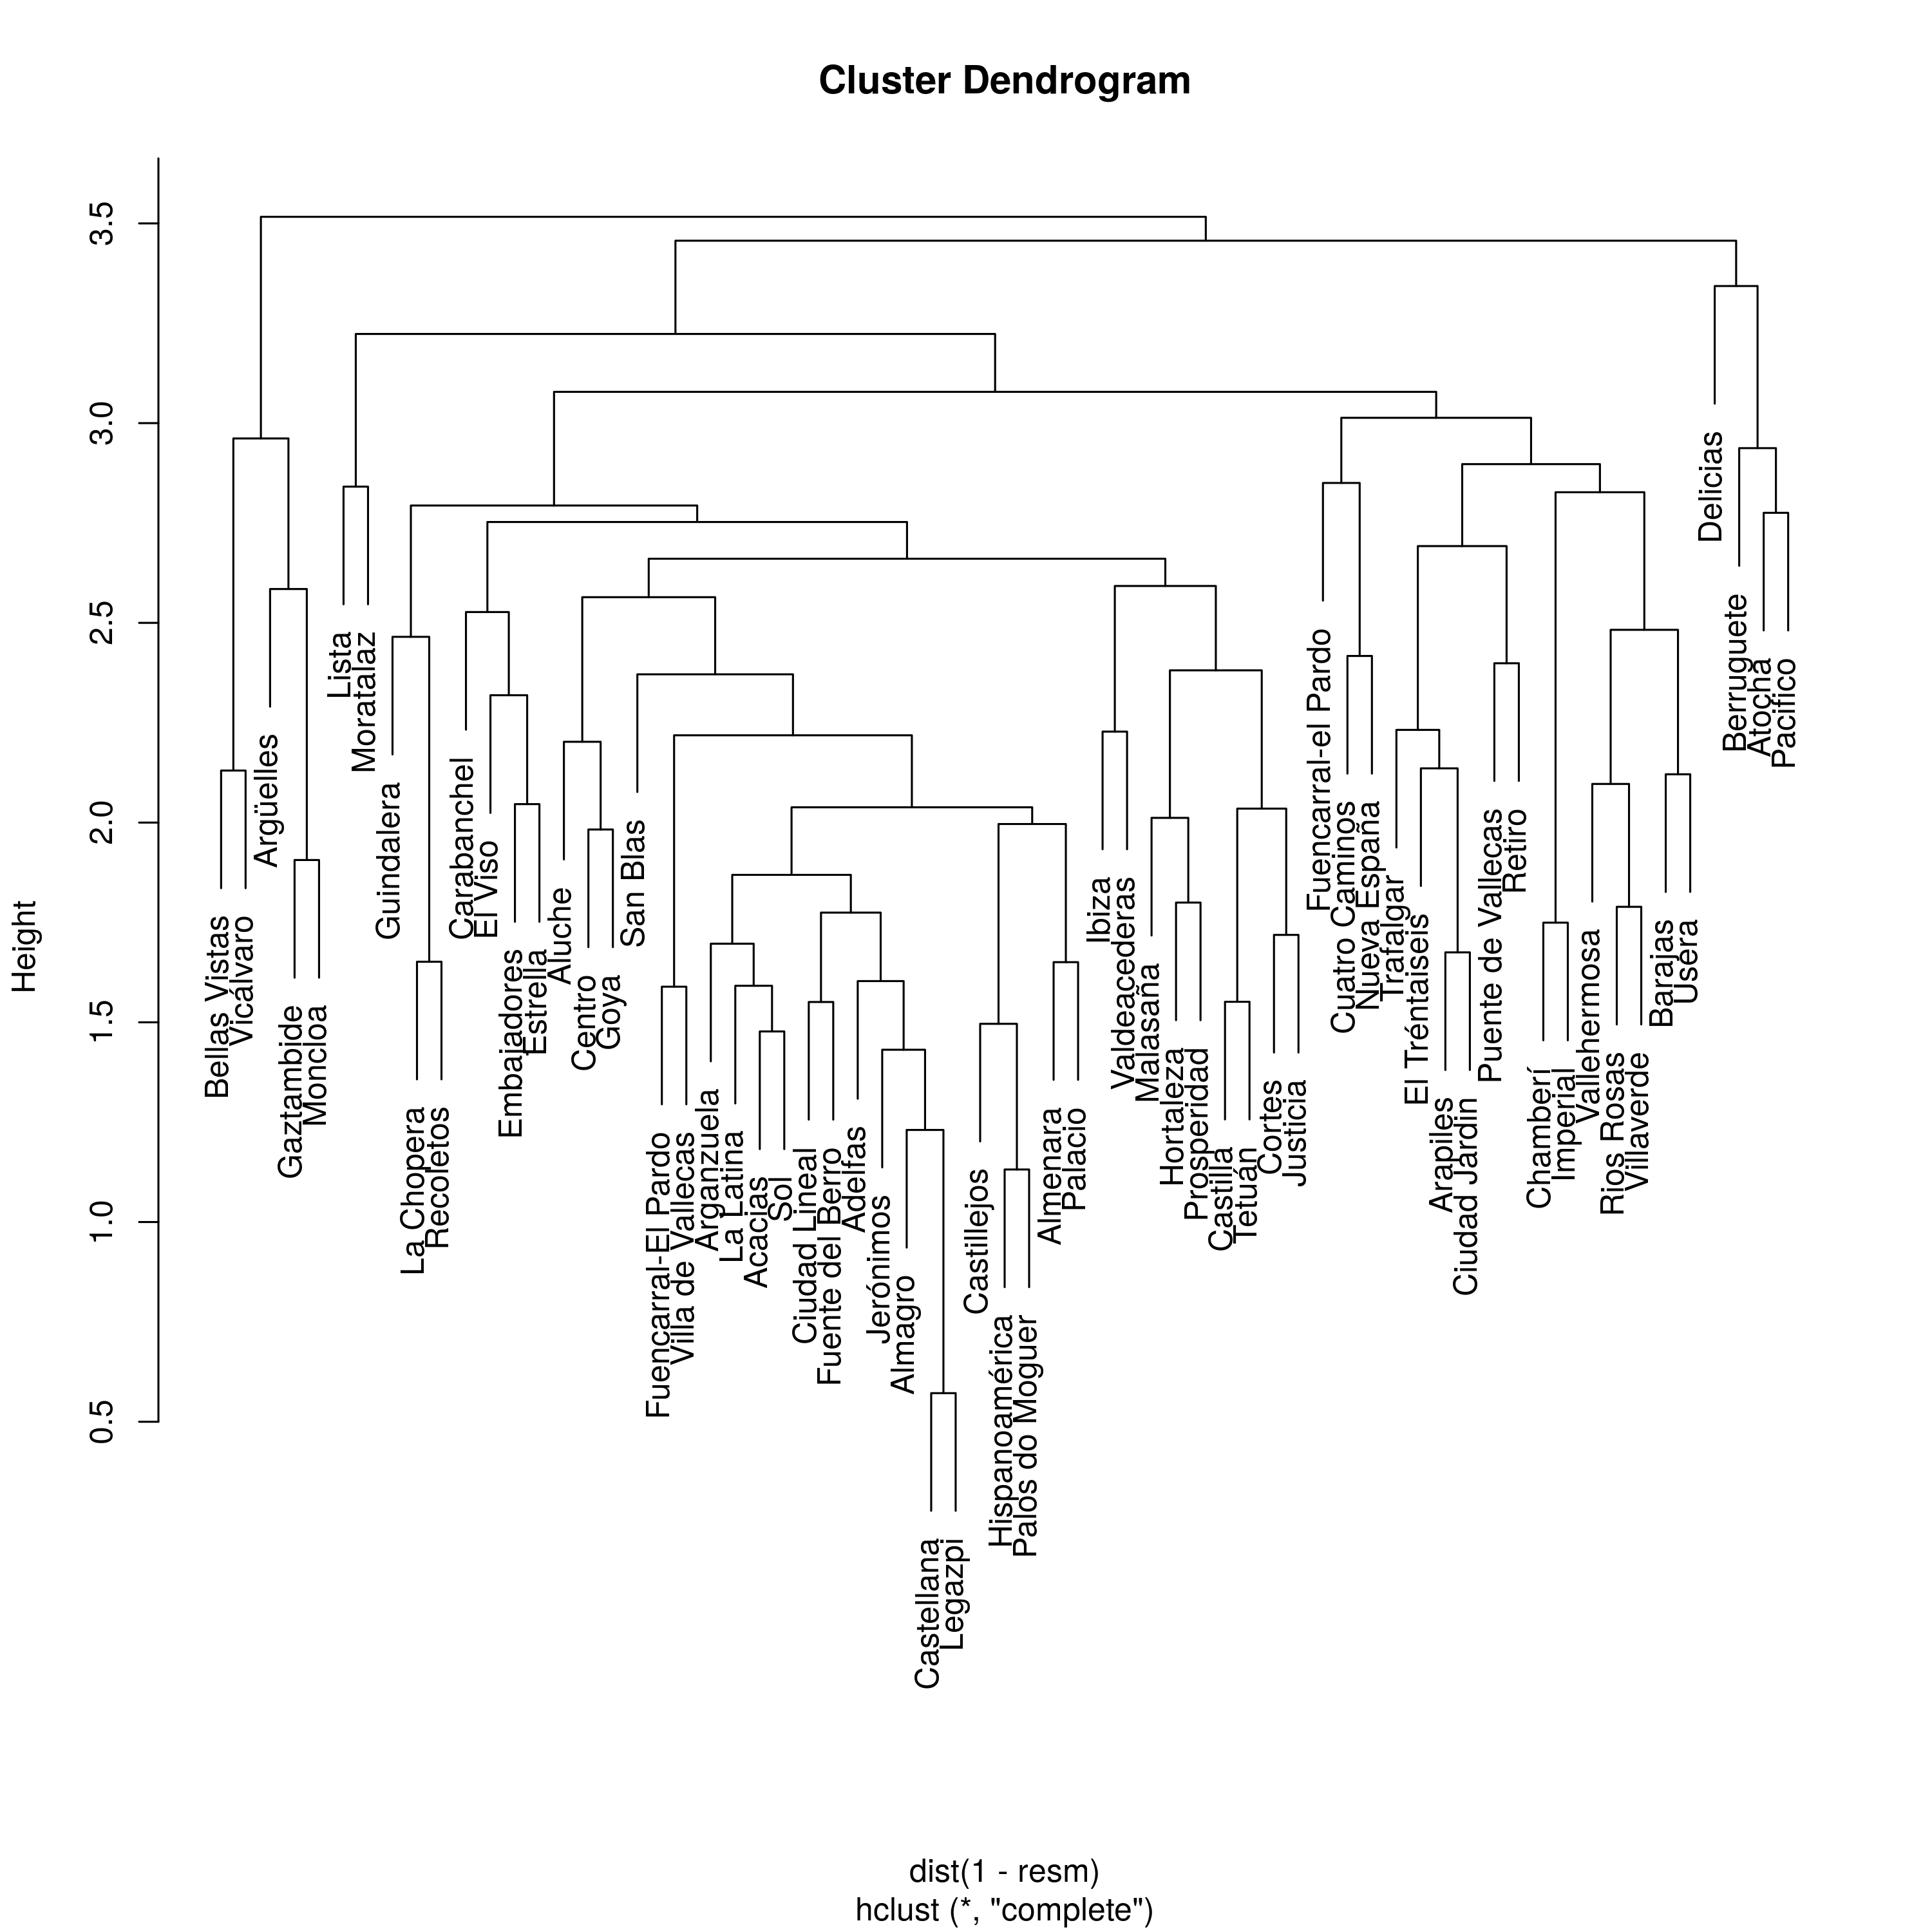

In [13]:
plot(hc)

Estableciendo un punto de corte en 0.9, ¿cuantos clusters aparecen?

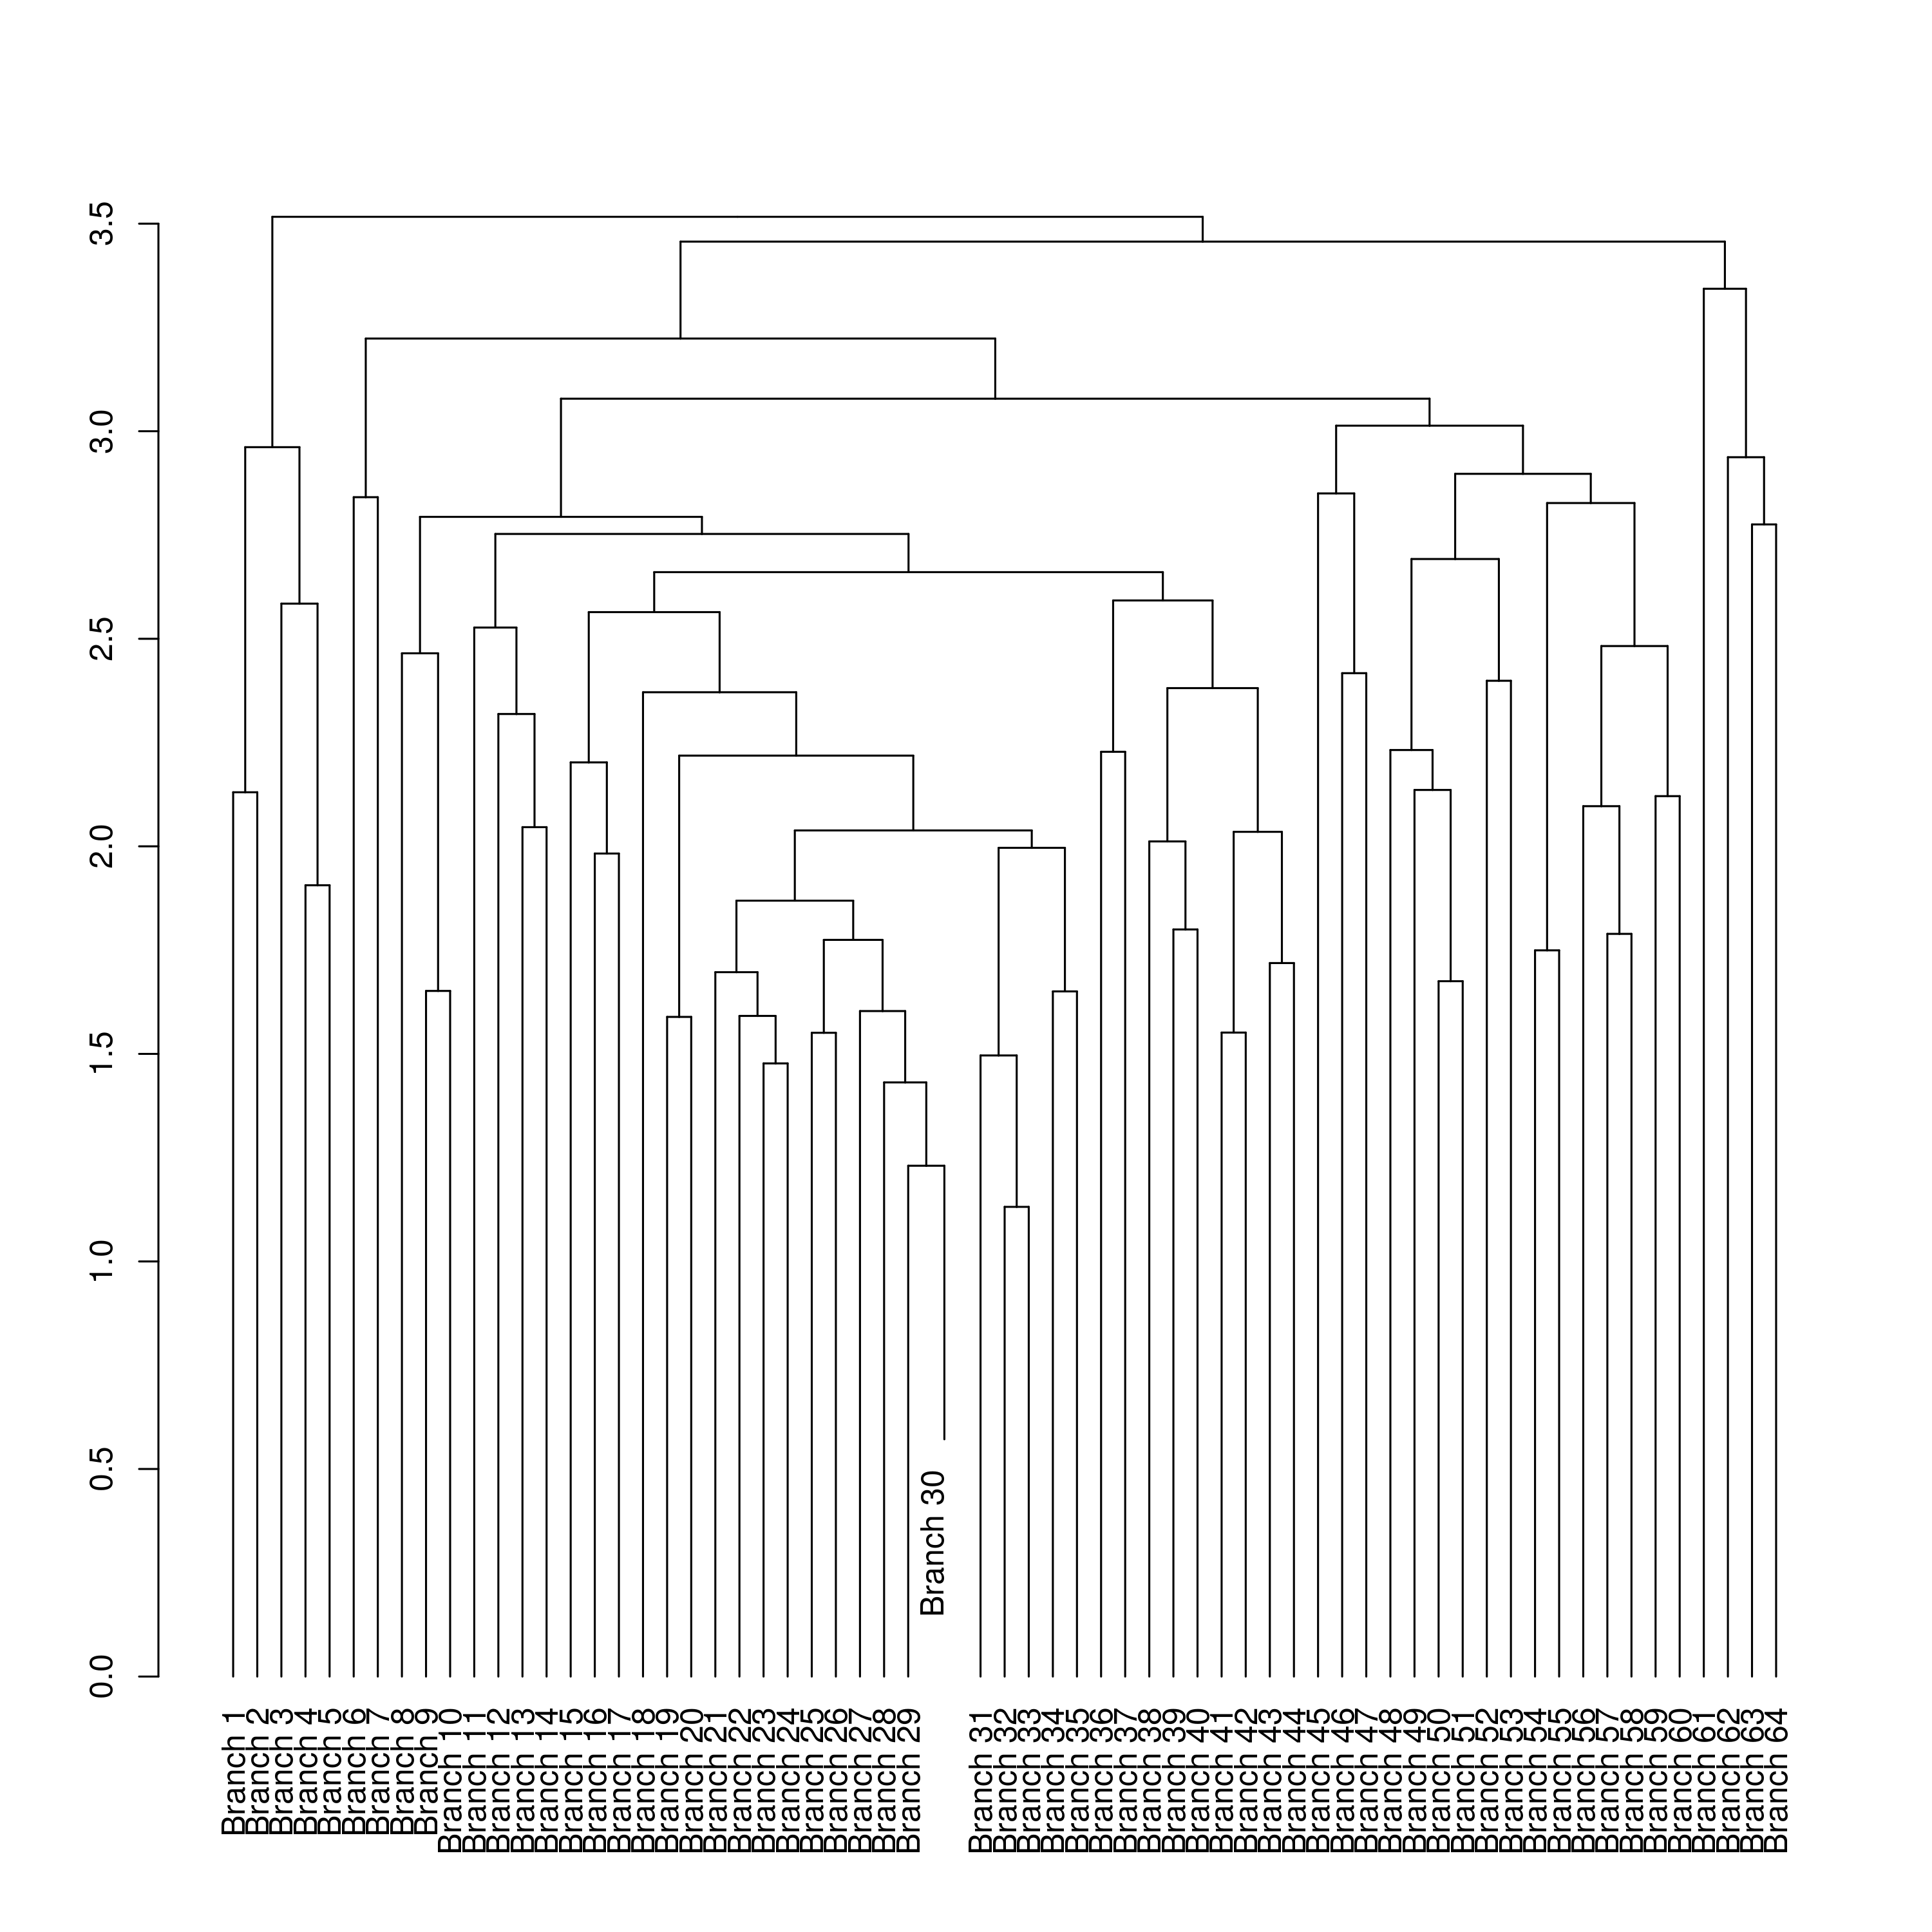

In [14]:
plot(cut(hcd, h=0.9)$upper)


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




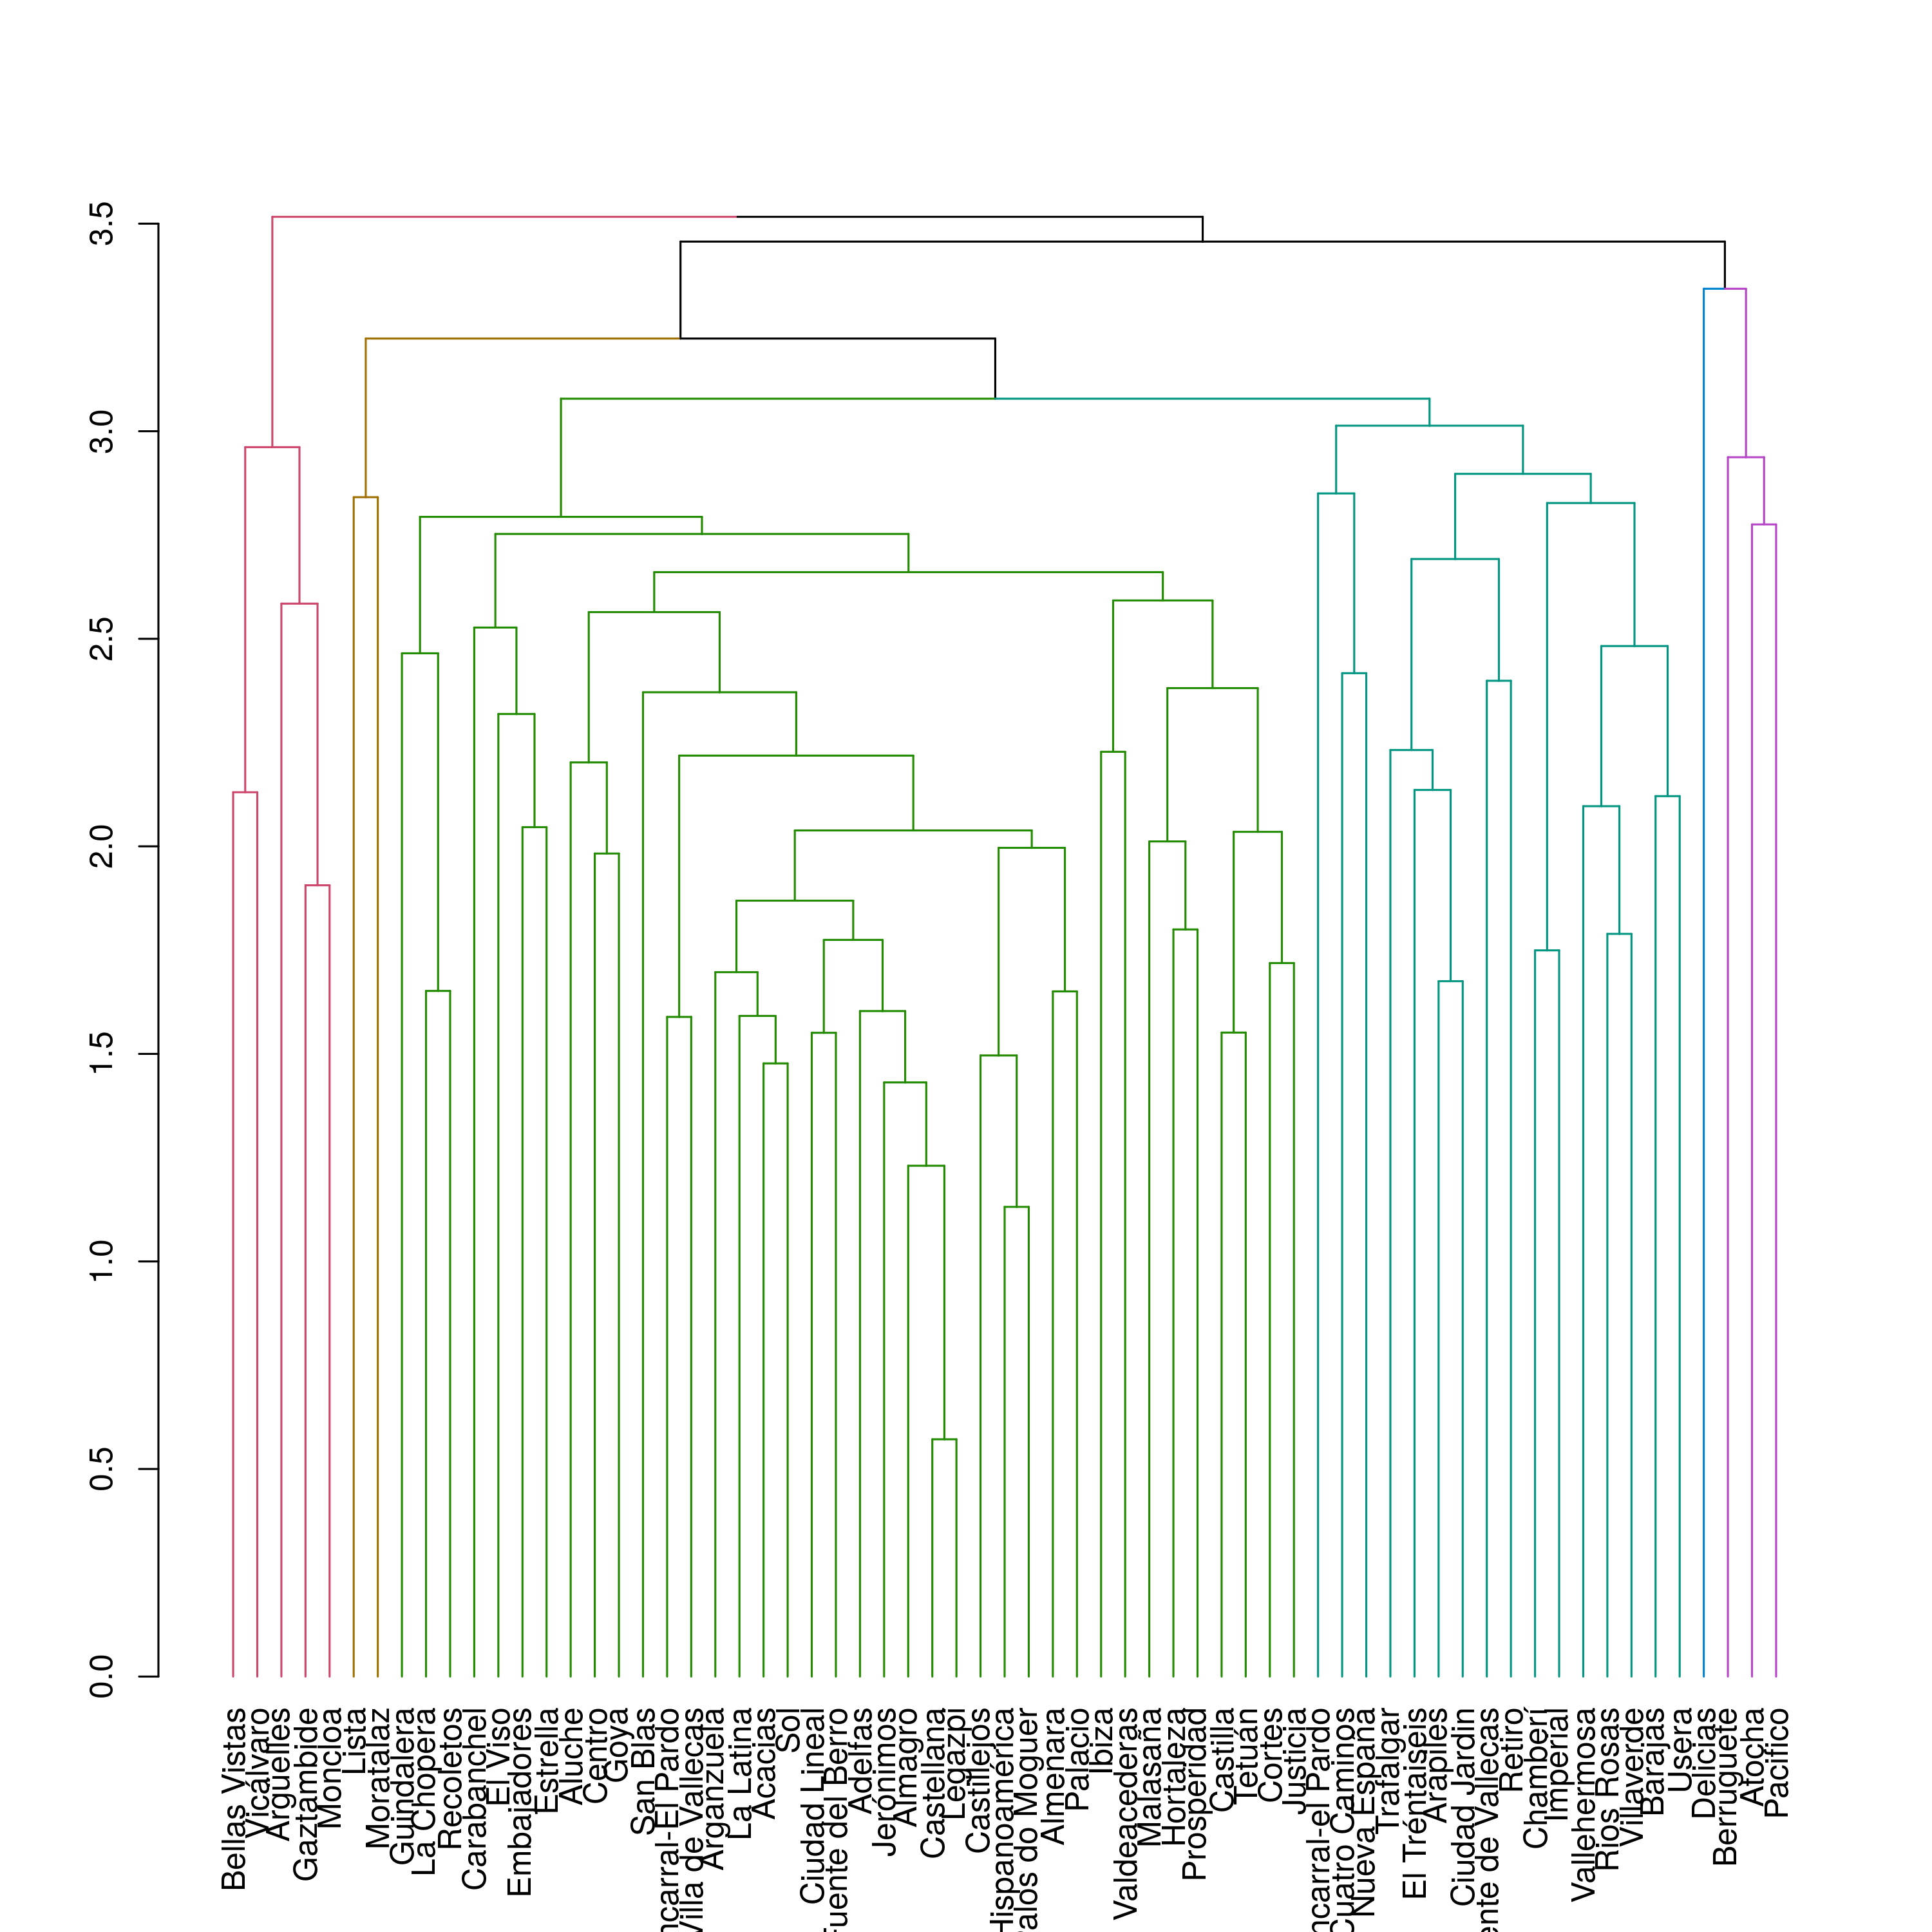

In [15]:
# Son demasiados, probemos a quedarnos con 6 clústeres
library(dendextend)
plot(color_branches(hcd, k=6))

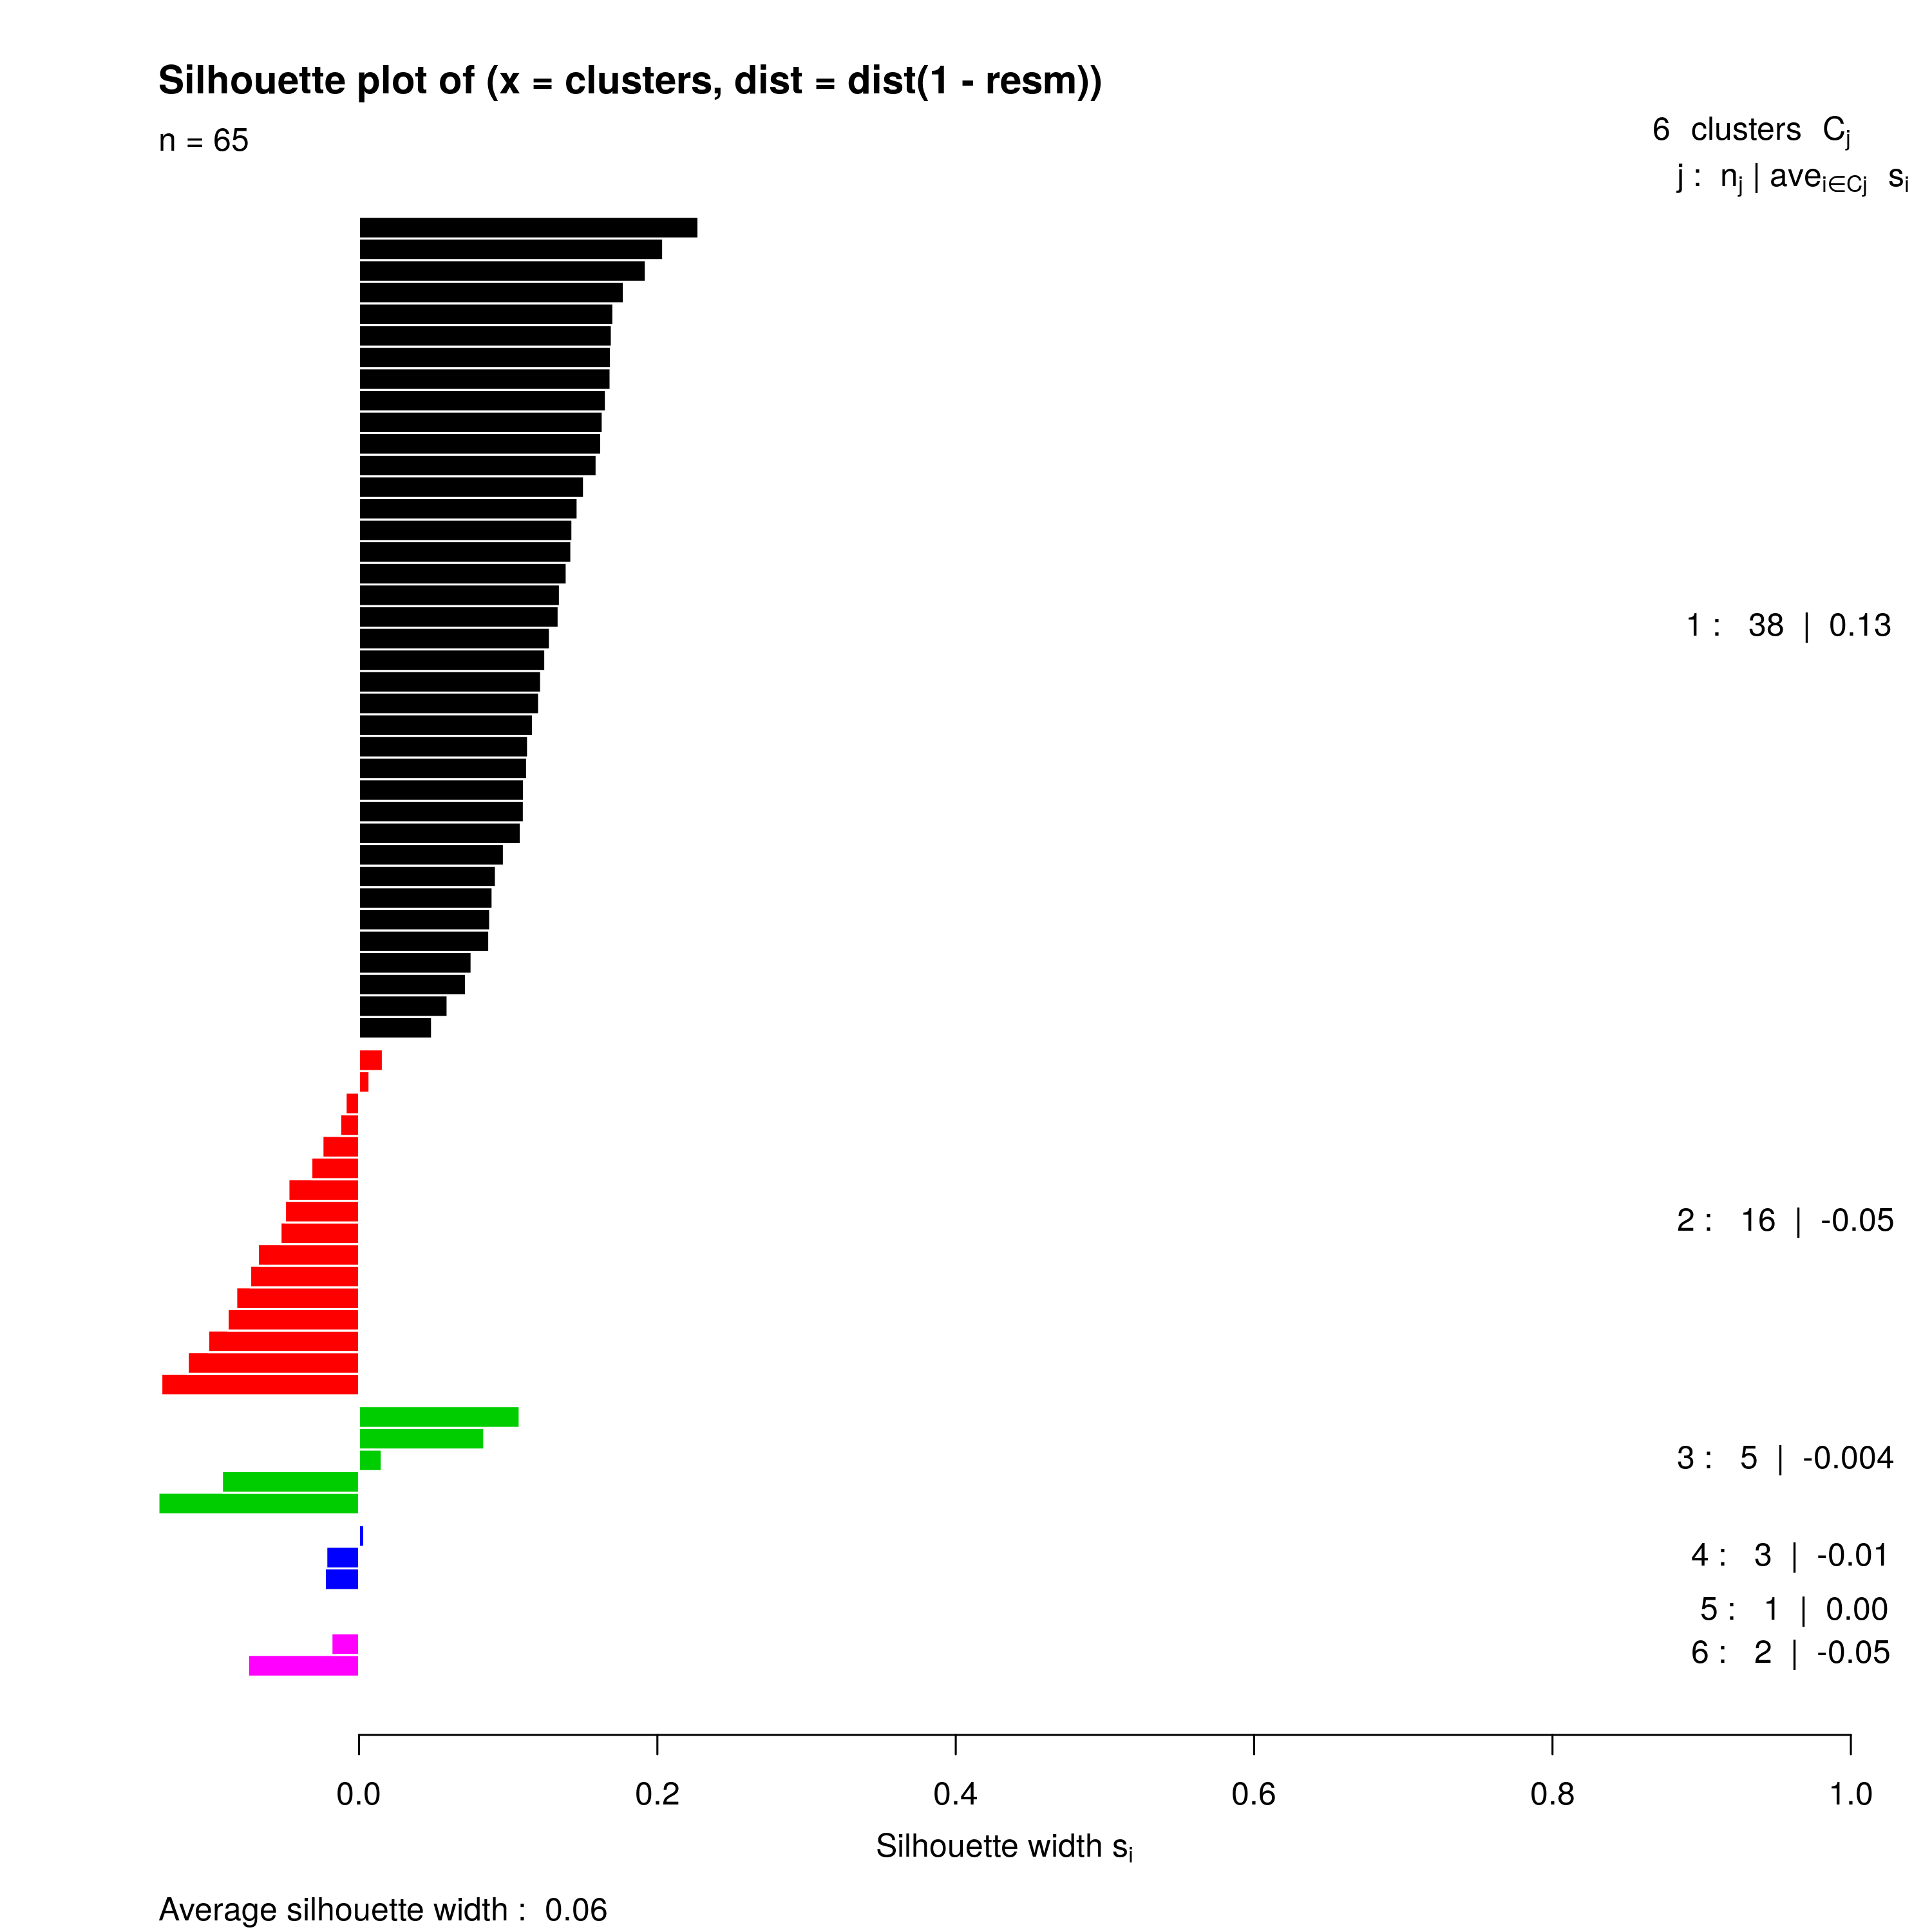

In [16]:
library(cluster)
clusters <- cutree(hcd, k=6)
ss<-silhouette(clusters, dist(1-resm))
plot(ss,col=1:max(clusters))

# Parece que algo se puede distinguir entre "grupo 1" y "el resto"

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [17]:
clusters <- as.data.frame(cutree(hc,k=6))
colnames(clusters) <- 'neighb_id'
clusters$Neighbourhood <- rownames(clusters)

In [18]:
df_madrid <- merge(df_madrid, clusters)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [19]:
colnames(df_madrid)

[1] "Neighbourhood"        "Accommodates"         "Bathrooms"           
 [4] "Bedrooms"             "Beds"                 "Price"               
 [7] "Square.Feet"          "Guests.Included"      "Extra.People"        
[10] "Review.Scores.Rating" "Latitude"             "Longitude"           
[13] "Square.Meters"        "neighb_id"

In [20]:
# Para estos grupos usaré un dataframe que no tenga valores NA
complete_df_madrid <- df_madrid[complete.cases(df_madrid$Square.Meters),]

#idx <- sample(1:nrow(complete_df_madrid),nrow(complete_df_madrid)*0.7)

# Me guardé los siguientes índices de una de las tantas pruebas que hice porque daba resultados decentes
idx <- c(100,45,162,96,147,35,172,66,58,13,122,51,12,167,103,113,136,129,166,6,143,28,171,60,78,98,2,106,135,111,8,85,42,82,47,101,141,164,49,159,144,94,48,64,123,146,149,55,80,153,173,131,18,163,137,3,70,20,102,79,52,72,81,76,154,119,53,4,126,130,99,142,1,150,9,14,121,88,138,95,127,118,34,38,117,170,32,73,89,43,30,114,91,168,39,139,151,120,169,11,17,27,105,41,19,23,165,158,75,84,108,86,37,36,109,152,24,62,160,107,16)
df_madrid.train <- complete_df_madrid[idx,]
df_madrid.test <- complete_df_madrid[-idx,]

In [21]:
# Esta fórmula es la que mejores resultados me ha dado en la mayoría de las ejecuciones
model_df_madrid <- glm(Square.Meters~Bedrooms*Price*Accommodates,
                       data=df_madrid.train)
summary(model_df_madrid)


Call:
glm(formula = Square.Meters ~ Bedrooms * Price * Accommodates, 
    data = df_madrid.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-52.998  -13.221   -2.428   10.078   73.381  

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                 30.078845  23.698591   1.269  0.20702   
Bedrooms                     2.305289  11.489399   0.201  0.84134   
Price                       -0.331518   0.323789  -1.024  0.30812   
Accommodates                 7.689382   5.013365   1.534  0.12793   
Bedrooms:Price               0.301944   0.104011   2.903  0.00446 **
Bedrooms:Accommodates       -0.533268   2.053619  -0.260  0.79560   
Price:Accommodates           0.006626   0.052682   0.126  0.90014   
Bedrooms:Price:Accommodates -0.019289   0.014082  -1.370  0.17352   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 474.7868)

    Null deviance:

In [22]:
df_madrid.test$Estimated.SqMet <- predict(model_df_madrid, df_madrid.test)

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

In [23]:
df_madrid.test$error <- NA
df_madrid.test$error <- sqrt((as.numeric(df_madrid.test$Square.Meters)-as.numeric(df_madrid.test$Estimated.SqMet))^2)

El error cuadrático medio es: 11.67708

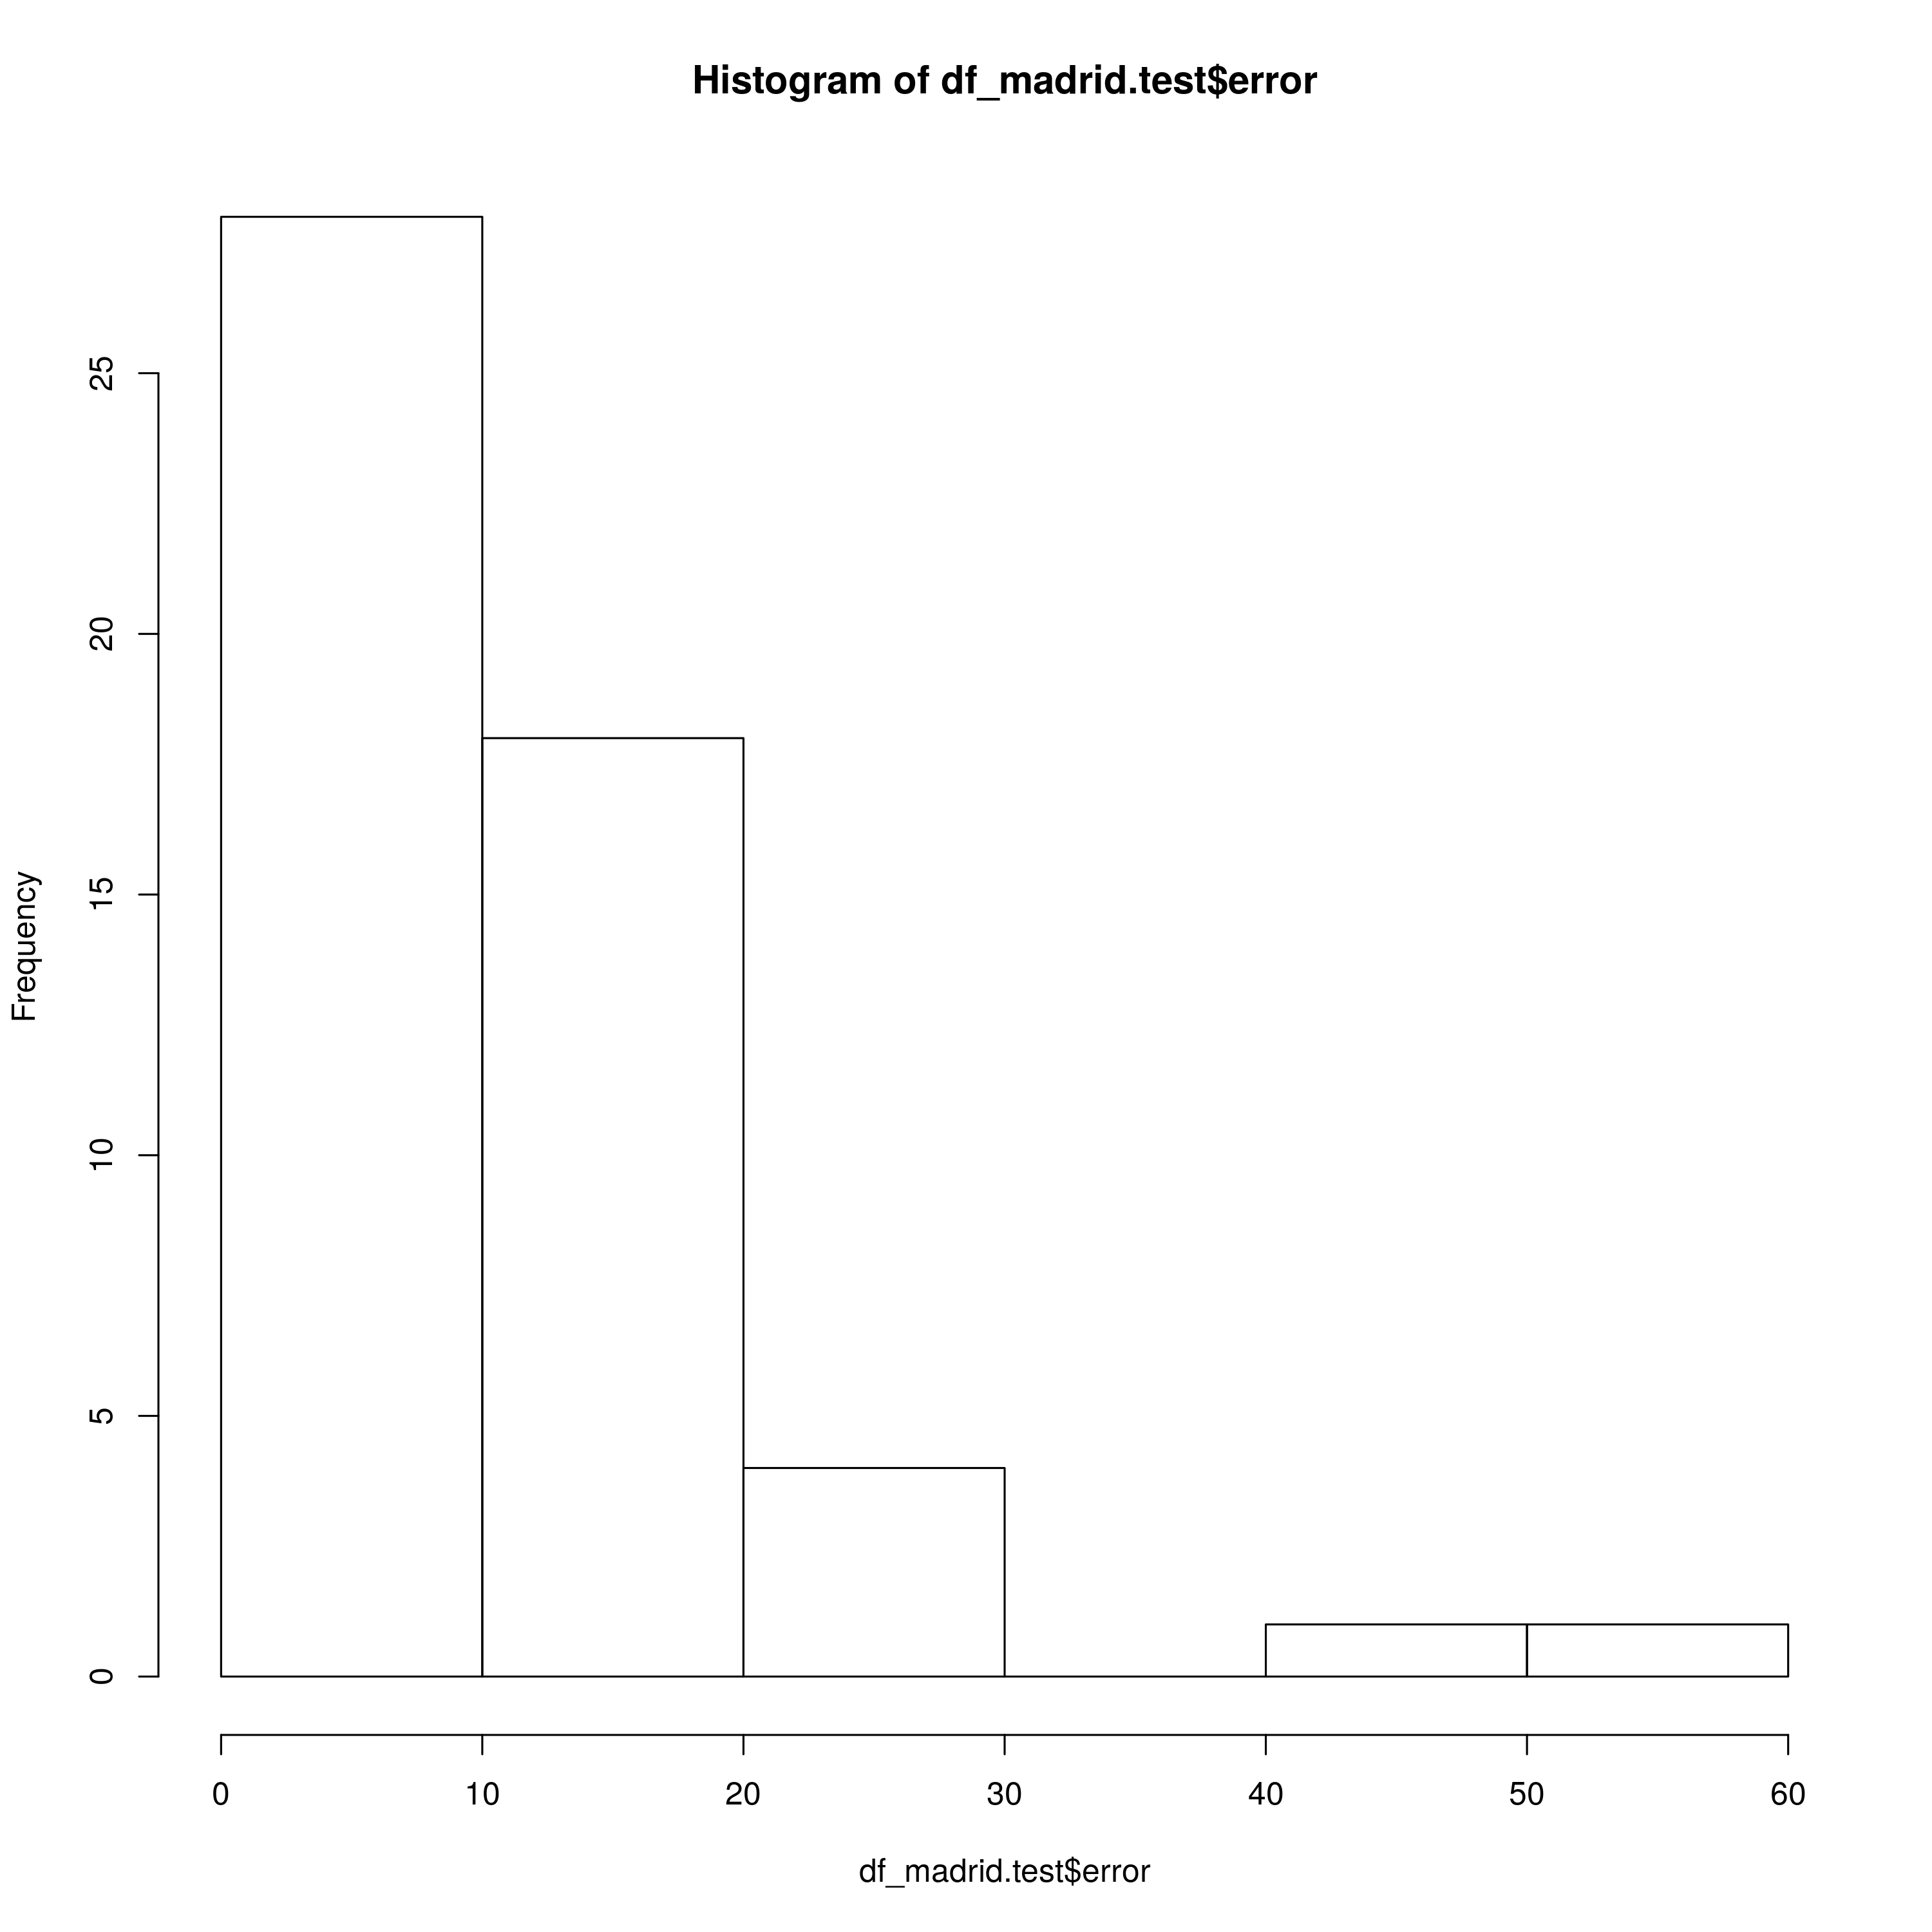

In [24]:
cat("El error cuadrático medio es:",sum(na.omit(df_madrid.test$error))/length(na.omit(df_madrid.test$error)))
hist(df_madrid.test$error)

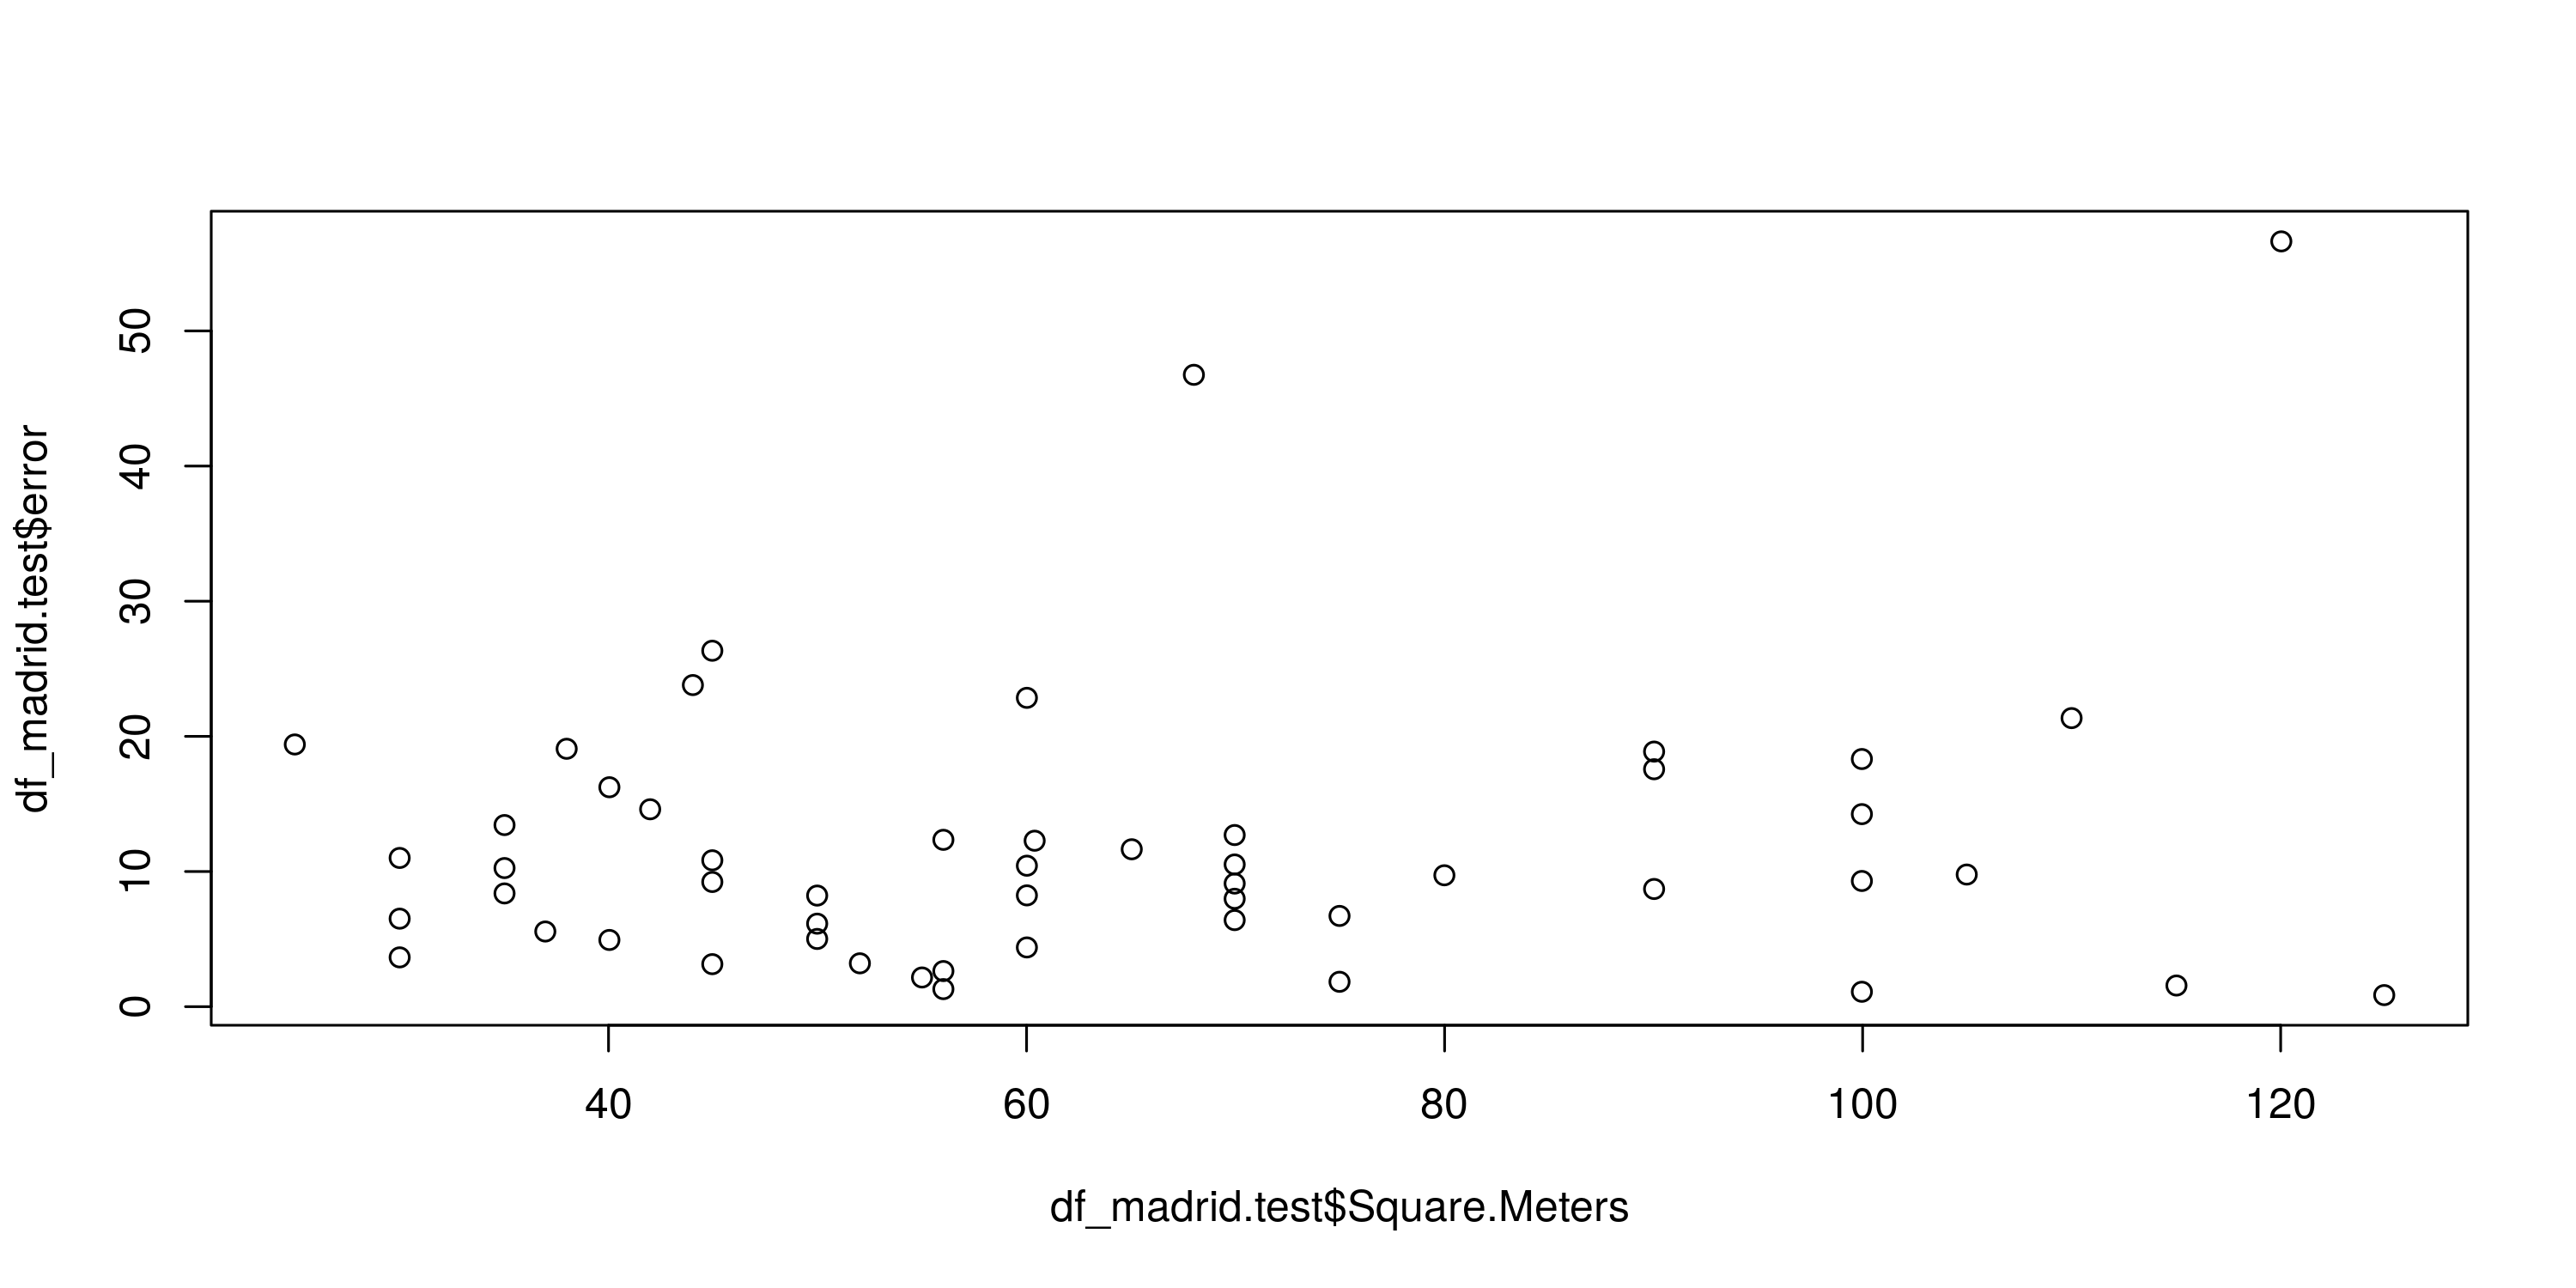

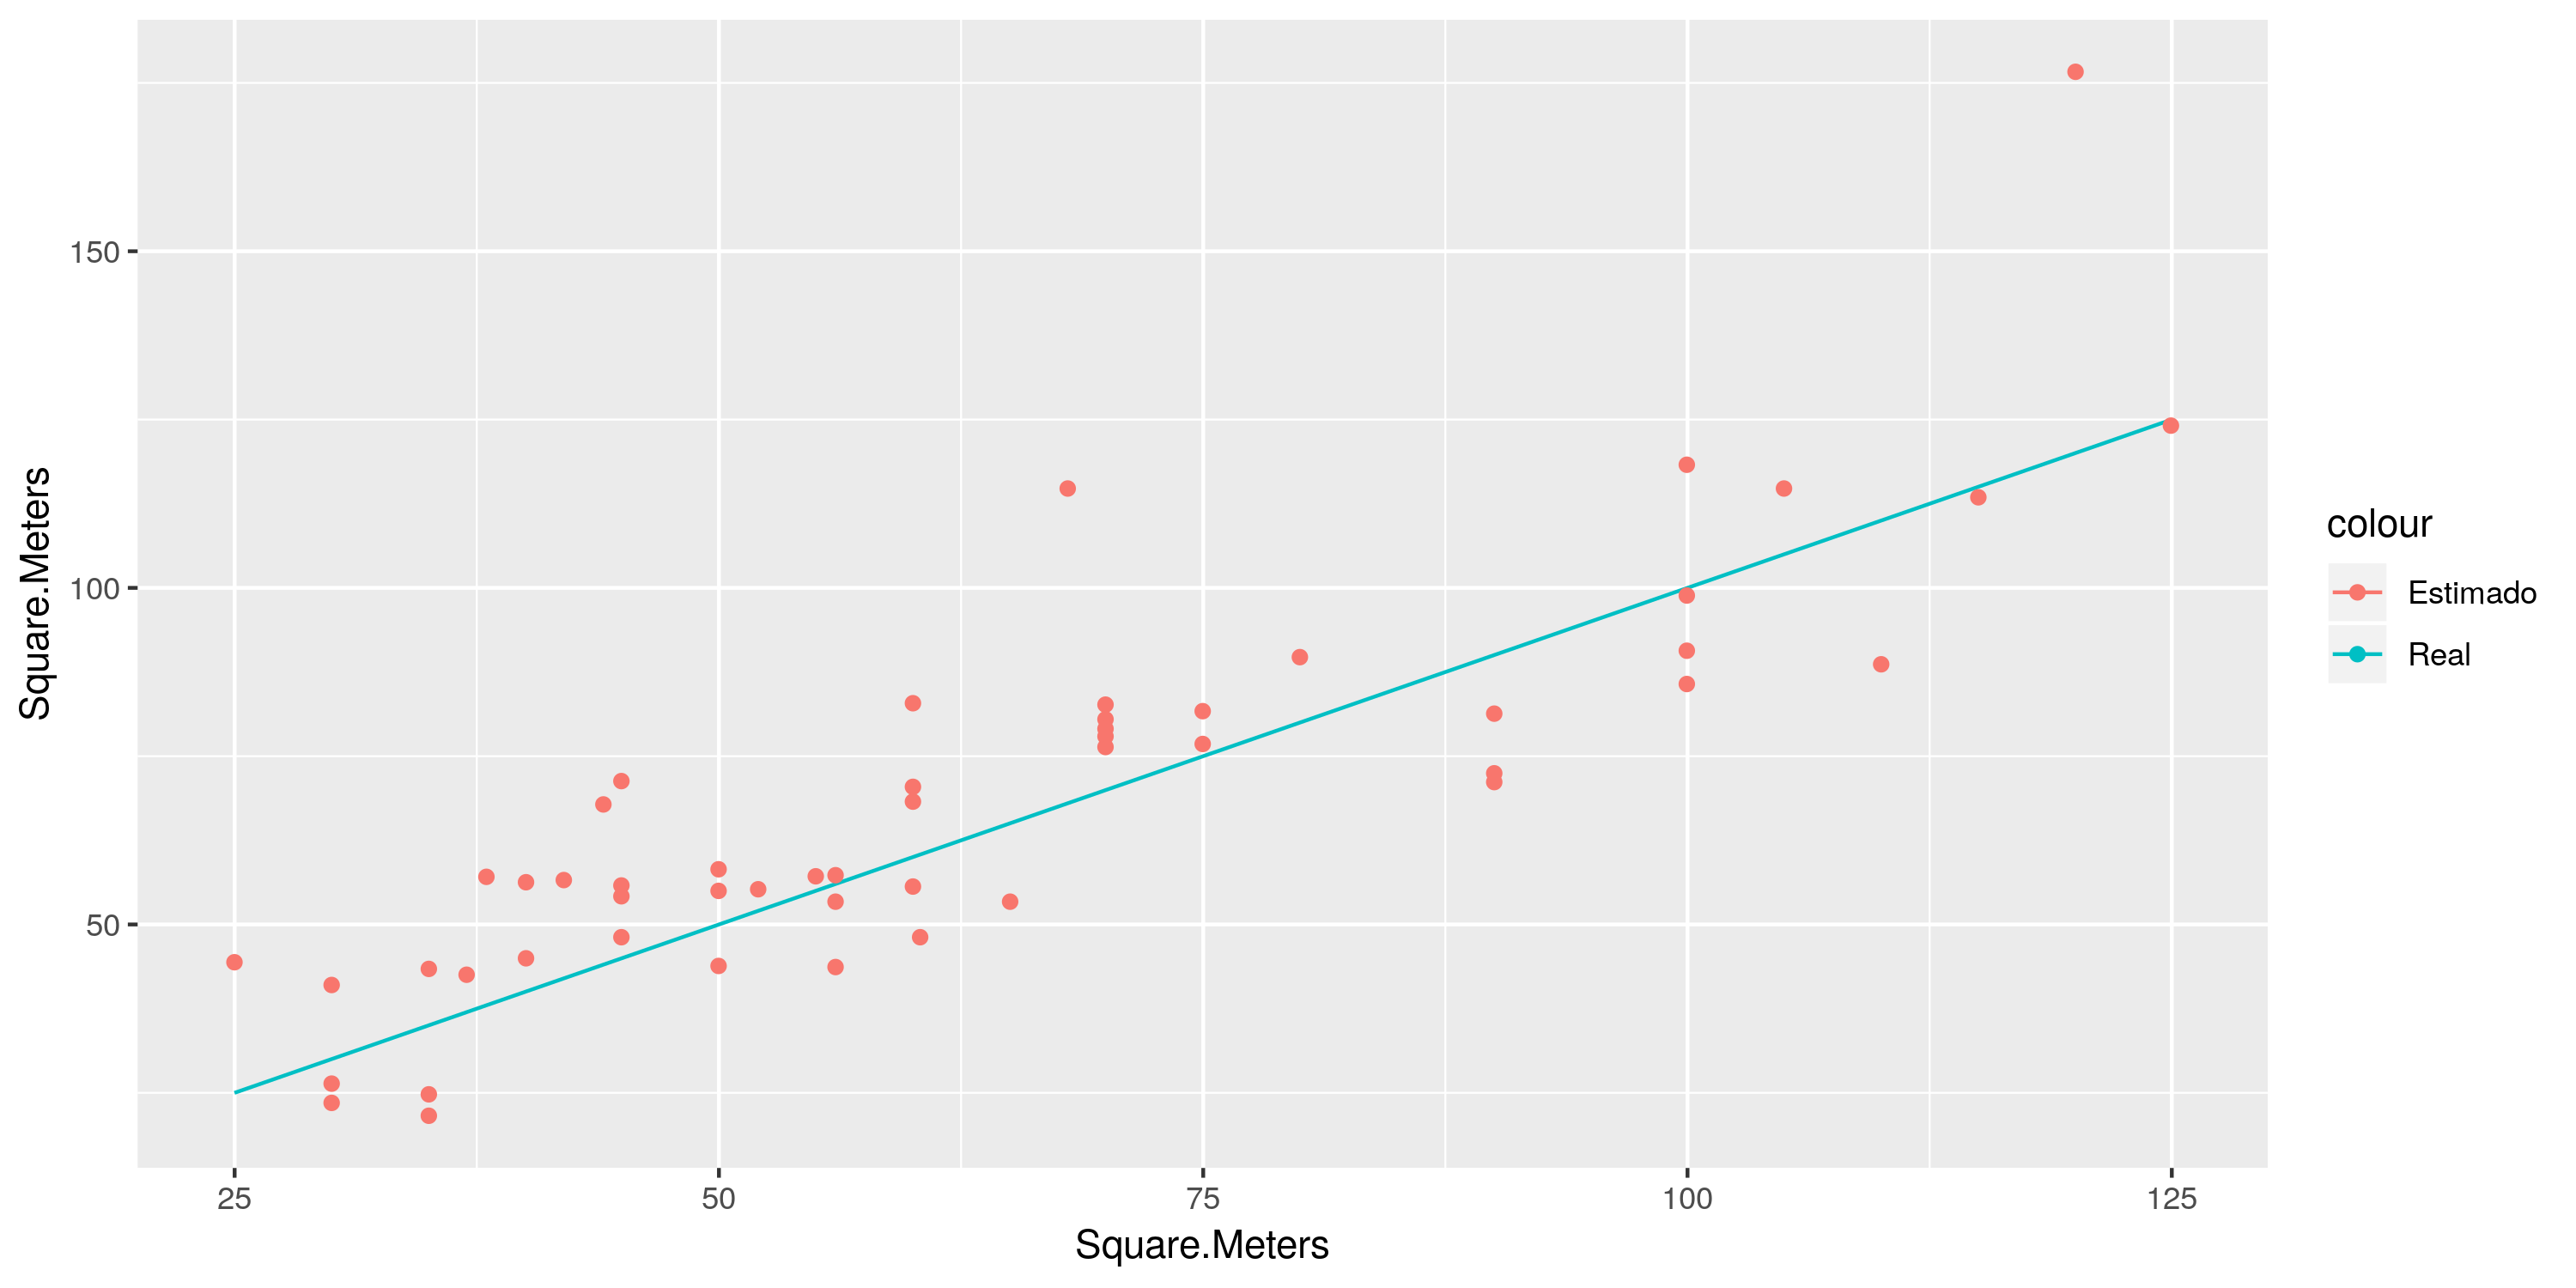

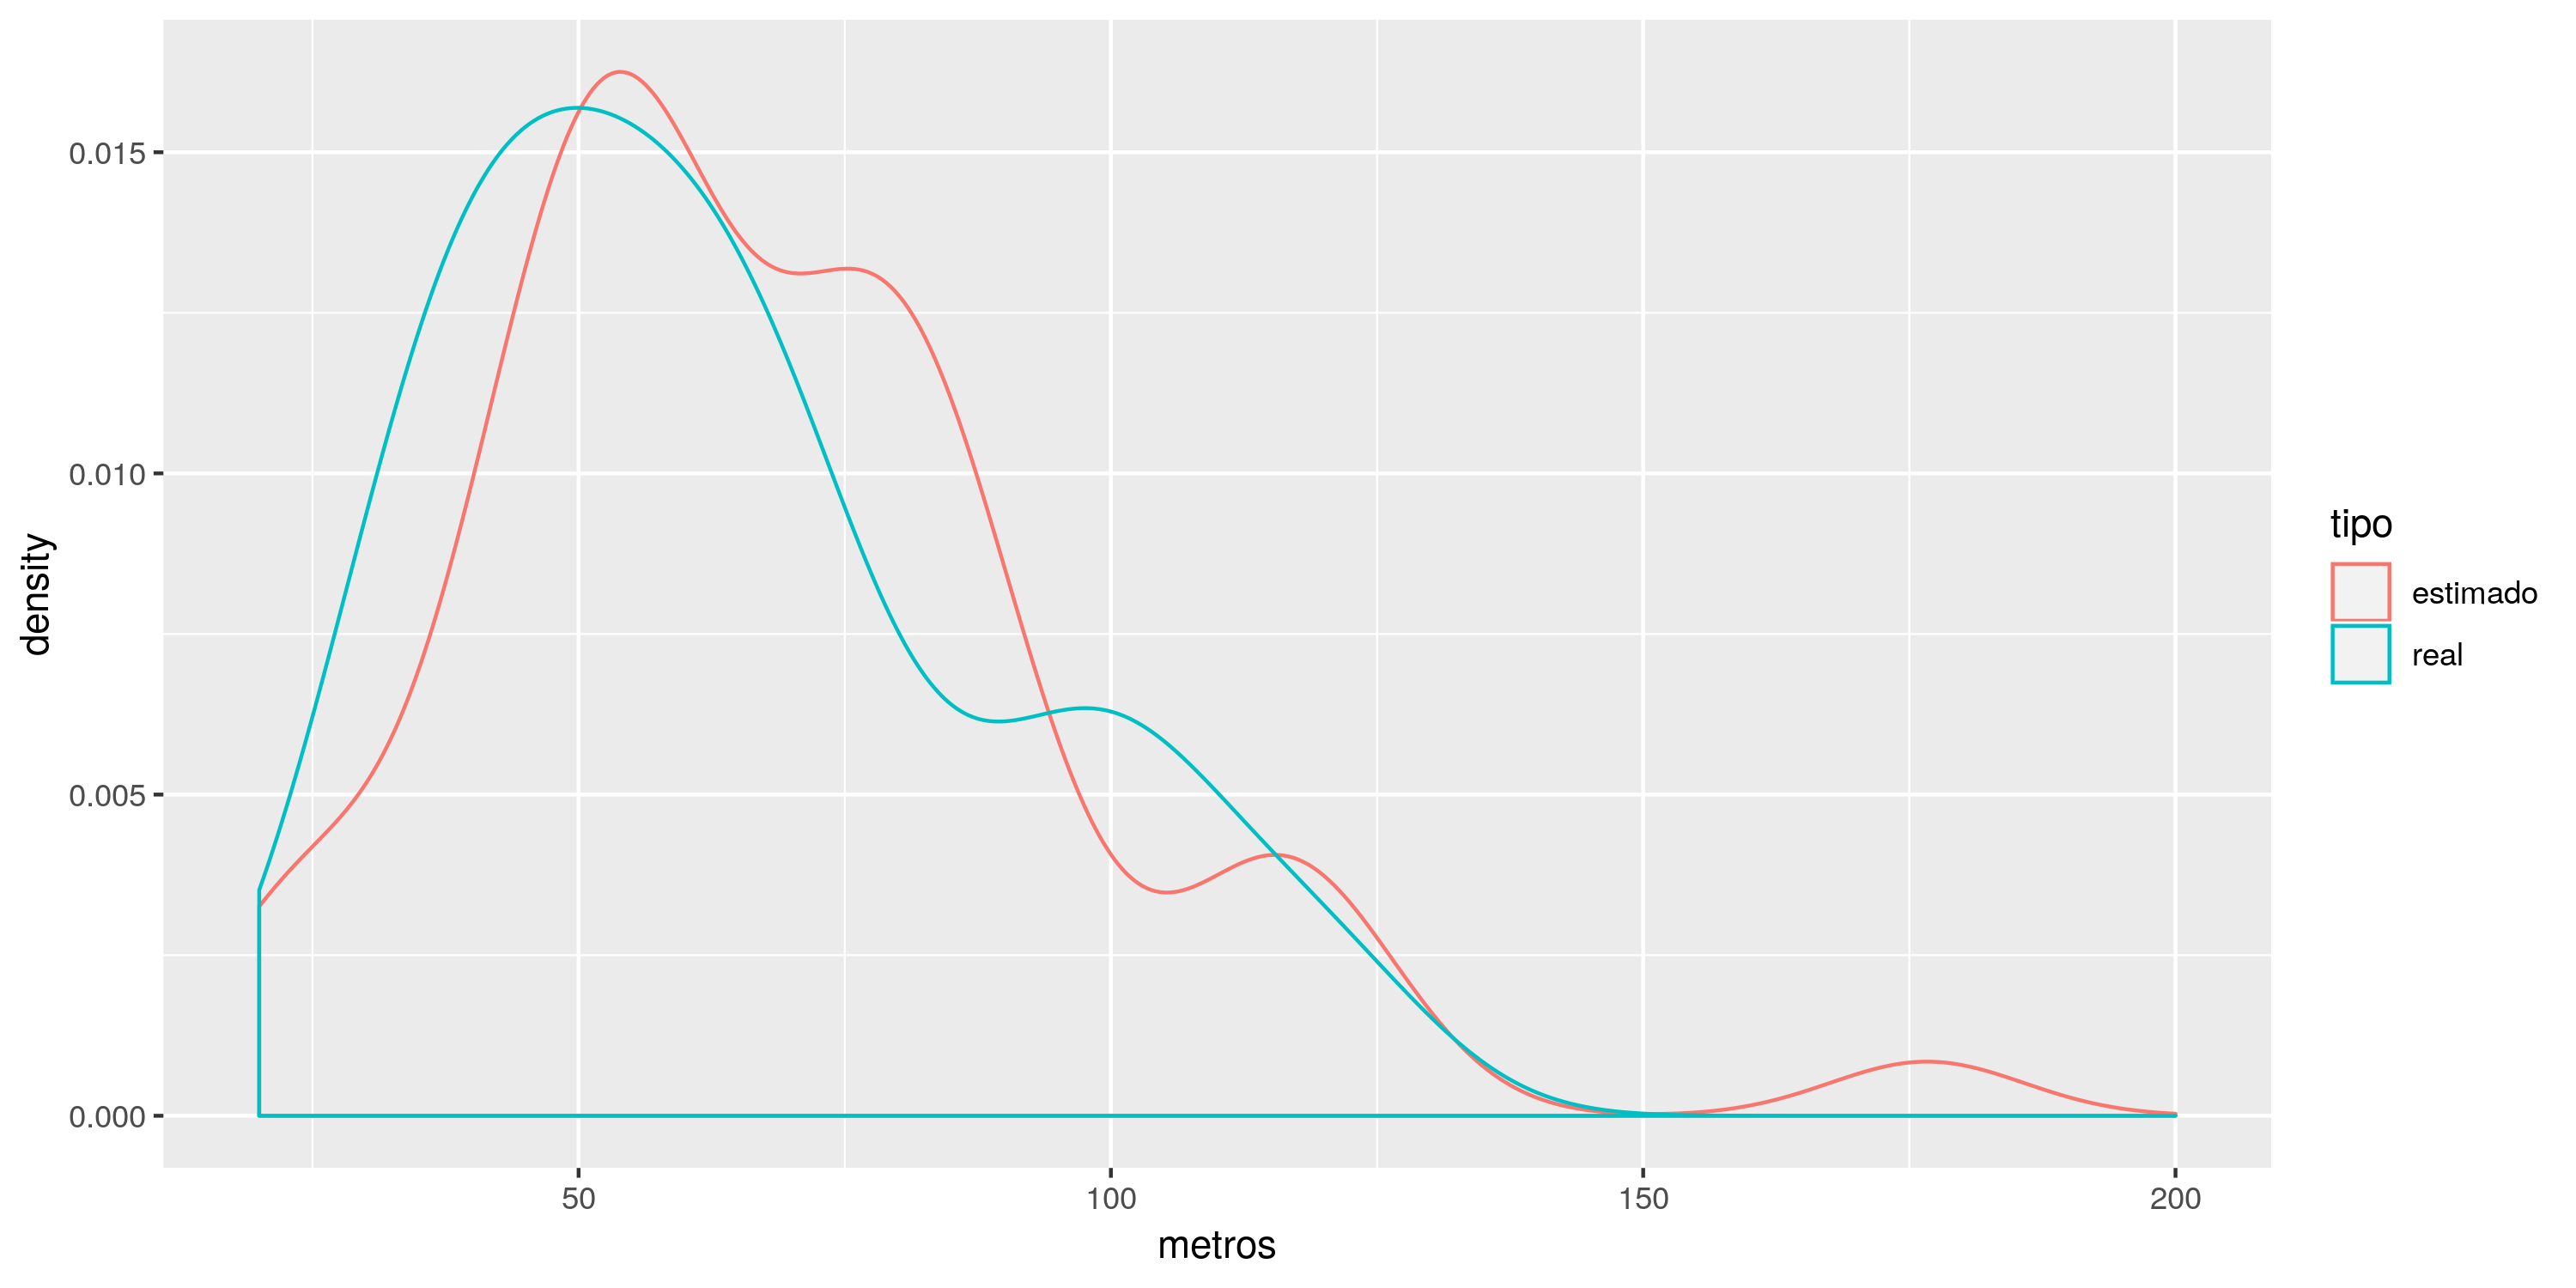

In [25]:
options(repr.plot.height=5,repr.plot.width=10,repr.plot.res = 300)

plot(df_madrid.test$Square.Meters,df_madrid.test$error)

ggplot(df_madrid.test,aes(x=Square.Meters))+
    geom_line(aes(y=Square.Meters,color="Real"))+
    geom_point(aes(y=Estimated.SqMet,color="Estimado"))

real <- as.data.frame(df_madrid.test$Square.Meters)
colnames(real) <- 'metros'
estimado <- as.data.frame(df_madrid.test$Estimated.SqMet)
colnames(estimado) <- 'metros'
real$tipo <- 'real'
estimado$tipo <- 'estimado'
curva <- rbind(real,estimado)
ggplot(curva, aes(metros, color=tipo))+geom_density()+xlim(20,200)

In [26]:
# Los datos pueden variar mucho dependiendo de las muestras en que se dividan train y test

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

In [27]:
Accommodates <- 6
Price <- 80
Bedrooms <- c(3,4,5)
Bathrooms <- 1
df_madrid.predicted <- data.frame(Accommodates,Price,Bedrooms,Bathrooms)
df_madrid.predicted$Square.Meters <- predict(model_df_madrid, df_madrid.predicted)

In [28]:
df_madrid.predicted
cat("Cada habitación suma",df_madrid.predicted$Square.Meters[df_madrid.predicted$Bedroom==4]-df_madrid.predicted$Square.Meters[df_madrid.predicted$Bedroom==3],"m².")

Accommodates,Price,Bedrooms,Bathrooms,Square.Meters
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,80,3,1,94.88154
6,80,4,1,108.88399
6,80,5,1,122.88643


Cada habitación suma 14.00245 m².

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [29]:
df_madrid$Square.Meters[is.na(df_madrid$Square.Meters)] <- predict(model_df_madrid, df_madrid[is.na(df_madrid$Square.Meters),])
head(df_madrid)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,Acacias,5,2,2,2,120,NA,4,20,95,40.40519,-3.706163,81.31678,1
2,Acacias,2,1,1,1,68,NA,1,0,94,40.40452,-3.707737,42.96313,1
3,Acacias,2,1,1,1,35,NA,1,0,96,40.40057,-3.702002,44.77485,1
4,Acacias,2,1,0,1,39,NA,1,0,100,40.40094,-3.702806,33.04524,1
5,Acacias,6,1,2,3,50,NA,2,10,68,40.40226,-3.712753,78.45937,1
6,Acacias,4,2,2,4,90,NA,2,25,92,40.40435,-3.706820,74.19132,1


Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [30]:
# Quitamos los datos redundantes y que no nos interesan del dataframe
clean_df_madrid <- na.omit(subset(df_madrid, select=-c(Neighbourhood,Square.Feet)))

In [31]:
# Apartamento que vamos a utilizar
apartment <- clean_df_madrid[2895,]
apartment

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
3448,2,1,0,1,50,1,0,92,40.42385,-3.702156,29.54431,1


In [32]:
# Con el último parámetro podemos indicar que queremos los 5 más similares, los 6, los 11 más similares...
# Por defecto toma como valor el 5, como pide el ejercicio
# La función también generaliza y podría servir para cualquier dataframe.

more_similar <- function(dataframe,compare,results=5) {
    pr_df <- prcomp(dataframe)
    t_data <- predict(pr_df, newdata=compare)
    dist <- rowSums((t_data[rep(1, times=nrow(pr_df$x)),]-pr_df$x)^2)
    similar <- sort(dist)[1:results]
    similar_data <- dataframe[which(dist==similar[1]),]
    for (i in 2:results) {
        similar_data[i,] <- dataframe[which(dist==similar[i]),]
    }
    similar_data
}

In [33]:
five_more_similar_apartments <- more_similar(clean_df_madrid,apartment)
five_more_similar_apartments

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
3448,2,1,0,1,50,1,0,92,40.42385,-3.702156,29.54431,1
216,2,1,0,1,49,1,0,92,40.41373,-3.731136,29.86258,1
5365,2,1,0,1,50,1,0,93,40.43186,-3.703460,29.54431,2
1144,2,1,0,1,50,2,0,93,40.41436,-3.697610,29.54431,1
4990,2,1,0,1,49,1,0,91,40.41491,-3.703457,29.86258,1


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?

In [34]:
pr_madrid <- prcomp(clean_df_madrid)
pr_madrid$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Accommodates,-2.132240e-02,-4.158242e-02,-1.508556e-02,-1.357334e-02,-0.6966753642,-1.755009e-01,-0.146256326,0.6776340617,0.0157314522,0.0204253948,-1.949185e-03,-5.546313e-05
Bathrooms,-6.317480e-03,-5.270150e-03,3.086822e-04,1.159259e-03,-0.0431787757,-1.671707e-02,0.033818310,-0.0087125894,-0.1479097880,-0.9872576271,3.504673e-03,4.594344e-04
Bedrooms,-1.119015e-02,-2.759869e-02,1.475460e-03,-1.809368e-04,-0.1328909508,-4.815743e-02,0.080519037,-0.1159716015,-0.9669631626,0.1555007590,8.377998e-04,2.587015e-04
Beds,-1.613952e-02,-3.001627e-02,-5.939267e-03,-4.838988e-03,-0.5752888508,-3.982475e-01,0.115164105,-0.6771911510,0.1928617977,0.0131908492,1.077840e-03,-2.511682e-04
Price,-9.381021e-01,3.455071e-01,1.356715e-02,-1.786374e-02,0.0083285552,8.509715e-05,0.001499378,0.0004104268,0.0005474040,0.0037418685,1.823260e-06,2.340641e-05
Guests.Included,-9.360659e-03,-1.504613e-02,-3.179484e-02,-4.083736e-03,-0.3989957454,8.983467e-01,0.047988504,-0.1700147201,0.0350130363,0.0002628140,-2.308694e-05,-3.183123e-04
Extra.People,-3.489266e-02,-6.241600e-02,-9.903376e-01,-1.119432e-01,0.0323841649,-2.286764e-02,0.002875274,-0.0011575615,-0.0023121439,-0.0004586225,7.903869e-06,1.456985e-05
Review.Scores.Rating,-1.502650e-02,1.523316e-02,-1.129992e-01,9.932760e-01,-0.0112447272,-3.423442e-03,0.001608364,0.0056754663,0.0008039407,0.0015798922,-6.355510e-05,-9.859555e-05
Latitude,-1.546358e-05,1.241621e-05,2.999473e-05,-1.076725e-04,0.0004757234,-3.256070e-04,0.002764440,-0.0006082810,-0.0008077567,-0.0021843620,-5.651250e-01,-8.249969e-01
Longitude,-8.908756e-06,-4.564213e-05,2.499175e-05,1.782402e-05,0.0002482263,-9.899863e-05,0.002555585,-0.0014589496,-0.0006029732,-0.0024837355,-8.249884e-01,5.651362e-01


In [35]:
sort(pr_madrid$rotation['neighb_id',], decreasing=T)[1]
sort(pr_madrid$rotation['neighb_id',], decreasing=F)[1]

PC7 
0.9774273

PC6 
-0.01877692

In [36]:
# PC7 presenta el valor absoluto más alto para neighb_id
# Esto significa que es la coordenada que mayor importancia le está dando a neighb_id